### Import libraries

In [1]:
%%capture
#!pip install scanpy
#!pip install KDEpy
#!pip install leidenalg

In [2]:
%%capture
# Remember to restart the kernel once installed
#!pip install -e ../../../tools/nomad/

In [22]:
import os
import sys

import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import scipy.sparse as sps
from scipy.stats import spearmanr, kendalltau, pearsonr, ranksums

# to be able to import from tools dir
module_path = os.path.abspath(os.path.join("../"))
if module_path not in sys.path:
    sys.path.append(module_path)

import tools.util as ut
import tools.countsplit as cs
import tools.scDEED as scd
import tools.clustering_opt as co
import tools.NB_est as nb
import tools.ClusterDE as cd

import fi_nomad as nmd
from fi_nomad.types import kernelInputTypes
from fi_nomad.types import KernelStrategy
from fi_nomad.types import InitializationStrategy

import warnings

warnings.filterwarnings("ignore")

import importlib
import logging

In [2]:
# logging has to manually turned on to see nomad output
logging.basicConfig(level=logging.INFO)

### Read data

In [3]:
data_path = "../data/S3"
figure_path = f"{data_path}/figures/raw_counts"
layer = "counts"

In [44]:
data = sc.read_h5ad(data_path + "/filtered_data_maxpool_processed_and_pca.h5ad")
data

AnnData object with n_obs × n_vars = 1544 × 5553
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale', 'embedding_reliability', 'reliability_score', 'null_reliability_score', 'leiden_opt'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'is_scd_outlier', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_mean', 'nb_umi', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'mean', 'std'
    uns: 'BacSC_params_PCA', 'PCA', 'leiden', 'leiden_opt_colors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'vst_counts'
    obsp: 'PCA_connectivities', 'PCA_distances'

### Countsplit

In [45]:
data_train, data_test = cs.countsplit_adata(
    data,
    data_dist="NB",
    beta_key="nb_overdisp_cutoff",
    layer=layer,
    min_genes=1,
    max_counts=1e9,
    seed=1234,
)

### Search latent dimension and momentum parameter

In [6]:
ks_2_check = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
betas_2_check = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
betas_2_check

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In case you don't want to rerun:

In [46]:
k_opt = 2
beta_opt = 0.0

In [9]:
select_cs_results = cs.select_3b_params_countsplit(
    data_train,
    data_test,
    potential_ks=ks_2_check,
    potential_betas=betas_2_check,
    layer=layer,
    maxiters=200,
)

################## LATENT DIM 10


INFO:fi_nomad.entry:	Initiating run, target_rank: 10, tolerance: None


################## BETA 0.0


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.787101013585925e-05 loop took 48.514394502999494 overall (0.24257197251499746/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 10, tolerance: None


################## BETA 0.1


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.9840011848136783e-05 loop took 46.45949924600427 overall (0.23229749623002136/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 10, tolerance: None


################## BETA 0.2


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.7048983611166477e-05 loop took 47.366909336997196 overall (0.236834546684986/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 10, tolerance: None


################## BETA 0.3


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.8084003133699298e-05 loop took 48.65266320199589 overall (0.24326331600997947/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 10, tolerance: None


################## BETA 0.4


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.6075984351336956e-05 loop took 45.0574030780117 overall (0.22528701539005852/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 10, tolerance: None


################## BETA 0.5


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.5504996301606297e-05 loop took 46.102578796009766 overall (0.23051289398004882/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 10, tolerance: None


################## BETA 0.6


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.5529006961733103e-05 loop took 49.058704929979285 overall (0.24529352464989643/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 10, tolerance: None


################## BETA 0.7


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.9489980079233646e-05 loop took 49.721167779003736 overall (0.24860583889501867/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 10, tolerance: None


################## BETA 0.8


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.7548987418413162e-05 loop took 46.313182961021084 overall (0.2315659148051054/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 10, tolerance: None


################## BETA 0.9


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.56330128852278e-05 loop took 49.75026389298728 overall (0.2487513194649364/ea)


################## LATENT DIM 9


INFO:fi_nomad.entry:	Initiating run, target_rank: 9, tolerance: None


################## BETA 0.0


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 4.4280983274802566e-05 loop took 53.43328082500375 overall (0.26716640412501874/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 9, tolerance: None


################## BETA 0.1


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 4.044797969982028e-05 loop took 53.08472043200163 overall (0.26542360216000815/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 9, tolerance: None


################## BETA 0.2


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.9668997740373015e-05 loop took 49.13407361699501 overall (0.24567036808497505/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 9, tolerance: None


################## BETA 0.3


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.7138012228533626e-05 loop took 51.91370233299676 overall (0.2595685116649838/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 9, tolerance: None


################## BETA 0.4


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 9.015598334372044e-05 loop took 45.9744307930232 overall (0.229872153965116/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 9, tolerance: None


################## BETA 0.5


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.1333998776972294e-05 loop took 45.76725425099721 overall (0.22883627125498607/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 9, tolerance: None


################## BETA 0.6


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 9.459198918193579e-05 loop took 45.896430730994325 overall (0.22948215365497163/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 9, tolerance: None


################## BETA 0.7


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.811999340541661e-05 loop took 45.90093798699672 overall (0.22950468993498363/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 9, tolerance: None


################## BETA 0.8


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.7151010474190116e-05 loop took 45.85570336697856 overall (0.2292785168348928/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 9, tolerance: None


################## BETA 0.9


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.114997525699437e-05 loop took 47.65657909400761 overall (0.23828289547003806/ea)


################## LATENT DIM 8


INFO:fi_nomad.entry:	Initiating run, target_rank: 8, tolerance: None


################## BETA 0.0


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.214302705600858e-05 loop took 46.083669260988245 overall (0.23041834630494124/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 8, tolerance: None


################## BETA 0.1


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.508200122974813e-05 loop took 46.96650179399876 overall (0.2348325089699938/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 8, tolerance: None


################## BETA 0.2


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.5362998712807894e-05 loop took 45.46921039998415 overall (0.22734605199992075/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 8, tolerance: None


################## BETA 0.3


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 4.121899837628007e-05 loop took 45.82974384300178 overall (0.2291487192150089/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 8, tolerance: None


################## BETA 0.4


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.8624024707823992e-05 loop took 47.298381661996245 overall (0.23649190830998124/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 8, tolerance: None


################## BETA 0.5


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.7506990591064095e-05 loop took 47.48185134999221 overall (0.23740925674996105/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 8, tolerance: None


################## BETA 0.6


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.6951980544254184e-05 loop took 48.11288244900061 overall (0.24056441224500305/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 8, tolerance: None


################## BETA 0.7


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 0.0009720990201458335 loop took 47.54894213899388 overall (0.23774471069496939/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 8, tolerance: None


################## BETA 0.8


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.5560002541169524e-05 loop took 51.16120280500036 overall (0.2558060140250018/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 8, tolerance: None


################## BETA 0.9


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.854902413673699e-05 loop took 52.005558570002904 overall (0.26002779285001454/ea)


################## LATENT DIM 7


INFO:fi_nomad.entry:	Initiating run, target_rank: 7, tolerance: None


################## BETA 0.0


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 4.1251012589782476e-05 loop took 47.75452191598015 overall (0.23877260957990074/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 7, tolerance: None


################## BETA 0.1


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.69539887085557e-05 loop took 42.45016516800388 overall (0.2122508258400194/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 7, tolerance: None


################## BETA 0.2


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 7.617697701789439e-05 loop took 44.16594199399697 overall (0.22082970996998483/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 7, tolerance: None


################## BETA 0.3


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.767000114545226e-05 loop took 44.768509630986955 overall (0.22384254815493476/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 7, tolerance: None


################## BETA 0.4


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.6049994630739093e-05 loop took 44.27875974500785 overall (0.22139379872503923/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 7, tolerance: None


################## BETA 0.5


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.930699313059449e-05 loop took 47.129923656000756 overall (0.23564961828000378/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 7, tolerance: None


################## BETA 0.6


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.8290989575907588e-05 loop took 45.53565594399697 overall (0.22767827971998486/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 7, tolerance: None


################## BETA 0.7


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.4888984626159072e-05 loop took 49.53585738901165 overall (0.24767928694505825/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 7, tolerance: None


################## BETA 0.8


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.8919009966775775e-05 loop took 51.87193936199765 overall (0.2593596968099882/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 7, tolerance: None


################## BETA 0.9


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.121799090877175e-05 loop took 50.167918588995235 overall (0.25083959294497615/ea)


################## LATENT DIM 6


INFO:fi_nomad.entry:	Initiating run, target_rank: 6, tolerance: None


################## BETA 0.0


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.4491007681936026e-05 loop took 44.976767841988476 overall (0.22488383920994237/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 6, tolerance: None


################## BETA 0.1


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.7292000595480204e-05 loop took 46.30195375598851 overall (0.23150976877994253/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 6, tolerance: None


################## BETA 0.2


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 4.146801074966788e-05 loop took 47.283472382987384 overall (0.23641736191493692/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 6, tolerance: None


################## BETA 0.3


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.048800863325596e-05 loop took 47.11125513998559 overall (0.23555627569992793/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 6, tolerance: None


################## BETA 0.4


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.3827993320301175e-05 loop took 46.91708951399778 overall (0.2345854475699889/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 6, tolerance: None


################## BETA 0.5


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.5052984710782766e-05 loop took 40.363517157995375 overall (0.20181758578997688/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 6, tolerance: None


################## BETA 0.6


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.619801671244204e-05 loop took 39.39236726099625 overall (0.19696183630498126/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 6, tolerance: None


################## BETA 0.7


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.6680005248636007e-05 loop took 46.40813996101497 overall (0.23204069980507483/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 6, tolerance: None


################## BETA 0.8


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.833201481029391e-05 loop took 45.37308933498571 overall (0.22686544667492853/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 6, tolerance: None


################## BETA 0.9


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.77850083168596e-05 loop took 59.259896587987896 overall (0.29629948293993946/ea)


################## LATENT DIM 5


INFO:fi_nomad.entry:	Initiating run, target_rank: 5, tolerance: None


################## BETA 0.0


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.6143010472878814e-05 loop took 42.708456913009286 overall (0.21354228456504643/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 5, tolerance: None


################## BETA 0.1


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.7340021915733814e-05 loop took 39.49411458597751 overall (0.19747057292988757/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 5, tolerance: None


################## BETA 0.2


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.399699926376343e-05 loop took 39.02508097401005 overall (0.19512540487005026/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 5, tolerance: None


################## BETA 0.3


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.717299503274262e-05 loop took 39.19617583998479 overall (0.19598087919992394/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 5, tolerance: None


################## BETA 0.4


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.5852001272141933e-05 loop took 39.07498026799294 overall (0.1953749013399647/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 5, tolerance: None


################## BETA 0.5


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.6891008019447327e-05 loop took 39.156387369002914 overall (0.19578193684501458/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 5, tolerance: None


################## BETA 0.6


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.356598270125687e-05 loop took 39.10374273499474 overall (0.1955187136749737/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 5, tolerance: None


################## BETA 0.7


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.6355002773925662e-05 loop took 39.12884543198743 overall (0.19564422715993715/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 5, tolerance: None


################## BETA 0.8


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.784698153845966e-05 loop took 39.1599015360116 overall (0.19579950768005802/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 5, tolerance: None


################## BETA 0.9


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.778798807412386e-05 loop took 43.98821716301609 overall (0.21994108581508043/ea)


################## LATENT DIM 4


INFO:fi_nomad.entry:	Initiating run, target_rank: 4, tolerance: None


################## BETA 0.0


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.694799331948161e-05 loop took 38.083955303998664 overall (0.1904197765199933/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 4, tolerance: None


################## BETA 0.1


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.415300696156919e-05 loop took 38.151235795987304 overall (0.19075617897993652/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 4, tolerance: None


################## BETA 0.2


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.6943976990878582e-05 loop took 43.68743499001721 overall (0.21843717495008605/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 4, tolerance: None


################## BETA 0.3


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.513101208023727e-05 loop took 41.70046117799939 overall (0.20850230588999694/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 4, tolerance: None


################## BETA 0.4


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.6408990379422903e-05 loop took 39.1556857030082 overall (0.19577842851504101/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 4, tolerance: None


################## BETA 0.5


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.4308974388986826e-05 loop took 39.52776294000796 overall (0.1976388147000398/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 4, tolerance: None


################## BETA 0.6


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.7475005481392145e-05 loop took 39.62659565298236 overall (0.1981329782649118/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 4, tolerance: None


################## BETA 0.7


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.7745001716539264e-05 loop took 45.831765568000264 overall (0.22915882784000133/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 4, tolerance: None


################## BETA 0.8


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.847498399205506e-05 loop took 43.041682064009365 overall (0.2152084103200468/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 4, tolerance: None


################## BETA 0.9


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.681300975382328e-05 loop took 45.5443132329965 overall (0.22772156616498251/ea)


################## LATENT DIM 3


INFO:fi_nomad.entry:	Initiating run, target_rank: 3, tolerance: None


################## BETA 0.0


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.002598532475531e-05 loop took 43.3629962420091 overall (0.21681498121004553/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 3, tolerance: None


################## BETA 0.1


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.7537986170500517e-05 loop took 45.07831005300977 overall (0.22539155026504887/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 3, tolerance: None


################## BETA 0.2


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.7595000574365258e-05 loop took 40.89820671099005 overall (0.20449103355495027/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 3, tolerance: None


################## BETA 0.3


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.6816996978595853e-05 loop took 43.133643619017676 overall (0.21566821809508838/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 3, tolerance: None


################## BETA 0.4


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.6792986318469048e-05 loop took 42.164543297025375 overall (0.21082271648512688/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 3, tolerance: None


################## BETA 0.5


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.6874011382460594e-05 loop took 41.6529172709852 overall (0.208264586354926/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 3, tolerance: None


################## BETA 0.6


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.725701779127121e-05 loop took 44.33997853499022 overall (0.2216998926749511/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 3, tolerance: None


################## BETA 0.7


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.56500206887722e-05 loop took 44.0542165429797 overall (0.2202710827148985/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 3, tolerance: None


################## BETA 0.8


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.0535971745848656e-05 loop took 42.41882732900558 overall (0.2120941366450279/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 3, tolerance: None


################## BETA 0.9


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 6.113399285823107e-05 loop took 42.01098350301618 overall (0.21005491751508087/ea)


################## LATENT DIM 2


INFO:fi_nomad.entry:	Initiating run, target_rank: 2, tolerance: None


################## BETA 0.0


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.155000740662217e-05 loop took 42.17502145198523 overall (0.21087510725992614/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 2, tolerance: None


################## BETA 0.1


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.614498953334987e-05 loop took 39.956080444011604 overall (0.19978040222005802/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 2, tolerance: None


################## BETA 0.2


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.374999505467713e-05 loop took 40.933340358024 overall (0.20466670179011998/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 2, tolerance: None


################## BETA 0.3


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.592999953776598e-05 loop took 39.06378347601276 overall (0.1953189173800638/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 2, tolerance: None


################## BETA 0.4


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.7301983209326863e-05 loop took 38.178847950010095 overall (0.1908942397500505/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 2, tolerance: None


################## BETA 0.5


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.4747976567596197e-05 loop took 37.14133354902151 overall (0.18570666774510755/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 2, tolerance: None


################## BETA 0.6


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.686202060431242e-05 loop took 39.62284362700302 overall (0.19811421813501512/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 2, tolerance: None


################## BETA 0.7


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.7196976589038968e-05 loop took 41.032647263025865 overall (0.20516323631512934/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 2, tolerance: None


################## BETA 0.8


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.8394977562129498e-05 loop took 40.862989450019086 overall (0.20431494725009544/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 2, tolerance: None


################## BETA 0.9


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.439599484205246e-05 loop took 41.79974771398702 overall (0.2089987385699351/ea)


################## LATENT DIM 1


INFO:fi_nomad.entry:	Initiating run, target_rank: 1, tolerance: None


################## BETA 0.0


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.8921000193804502e-05 loop took 42.7913849610195 overall (0.2139569248050975/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 1, tolerance: None


################## BETA 0.1


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 5.850300658494234e-05 loop took 40.004140750010265 overall (0.20002070375005132/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 1, tolerance: None


################## BETA 0.2


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.472399501129985e-05 loop took 37.985752778011374 overall (0.18992876389005686/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 1, tolerance: None


################## BETA 0.3


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.5542016373947263e-05 loop took 39.03405378499883 overall (0.19517026892499417/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 1, tolerance: None


################## BETA 0.4


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.966700751334429e-05 loop took 39.16293430898804 overall (0.1958146715449402/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 1, tolerance: None


################## BETA 0.5


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.434601239860058e-05 loop took 39.09819503099425 overall (0.19549097515497124/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 1, tolerance: None


################## BETA 0.6


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.4428987419232726e-05 loop took 39.251349480007775 overall (0.19625674740003887/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 1, tolerance: None


################## BETA 0.7


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 0.0001626370067242533 loop took 39.2005817629979 overall (0.1960029088149895/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 1, tolerance: None


################## BETA 0.8


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.8748024962842464e-05 loop took 39.23075232899282 overall (0.19615376164496412/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 1, tolerance: None


################## BETA 0.9


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.591598942875862e-05 loop took 39.2450965080061 overall (0.1962254825400305/ea)


<Axes: xlabel='k', ylabel='loss'>

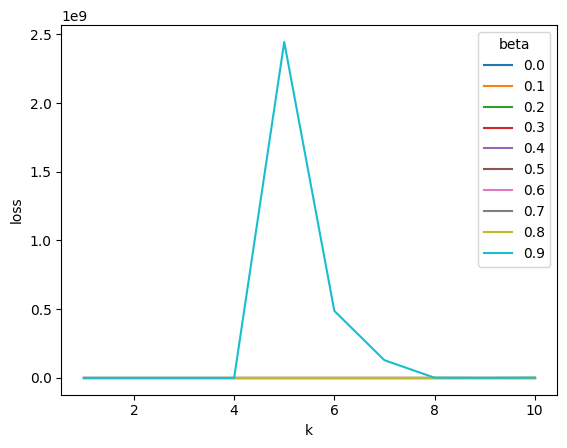

In [10]:
sns.lineplot(data=select_cs_results, x="k", y="loss", hue="beta", palette="tab10")

In [13]:
k_opt, beta_opt, _ = select_cs_results.sort_values(by="loss").iloc[0]
k_opt = int(k_opt)
beta_opt = float(beta_opt)

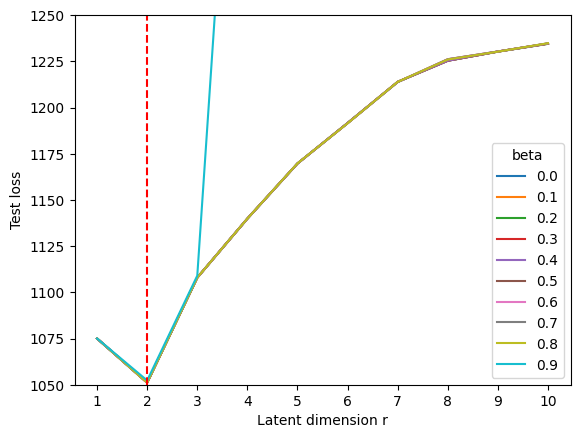

In [33]:
fig, ax = plt.subplots()
latent_dim_search_counts = sns.lineplot(
    data=select_cs_results, x="k", y="loss", hue="beta", palette="tab10"
)
plt.ylabel("Test loss")
plt.xlabel("Latent dimension r")
plt.ylim([1050, 1250])
ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.axvline(x=k_opt, color="red", linestyle="dashed")

plt.savefig(f"{figure_path}/select_r_beta_cs.svg")
plt.show()

In [9]:
print(f"Optimal latent dim: {k_opt}")
print(f"Optimal beta: {beta_opt}")

Optimal latent dim: 2
Optimal beta: 0.0


In [47]:
data.uns["BacSC_params_NMD"] = {"k_opt": k_opt, "beta_opt": beta_opt}

## Fit NMD with found parameters

In [48]:
n, p = data.X.shape

In [49]:
X_nmd = ut.convert_to_dense(data, layer=layer)
X_nmd = X_nmd.astype(float)
W0, H0 = cs.nuclear_norm_init(X_nmd, n, p, k_opt)
Theta0 = W0 @ H0

In [50]:
init_strat = InitializationStrategy.KNOWN_MATRIX
kernel_strat = KernelStrategy.MOMENTUM_3_BLOCK_MODEL_FREE

In [51]:
kernel_params = kernelInputTypes.Momentum3BlockAdditionalParameters(
    momentum_beta=beta_opt,
    candidate_factor_W0=W0,
    candidate_factor_H0=H0,
)
nmd_result = nmd.decompose(
    X_nmd,
    k_opt,
    kernel_strategy=kernel_strat,
    initialization=init_strat,
    kernel_params=kernel_params,
    manual_max_iterations=200,
    verbose=True,
    tolerance=None,
)

INFO:fi_nomad.entry:	Initiating run, target_rank: 2, tolerance: None
INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 0.00014790800196351483 loop took 48.939945126003295 overall (0.24469972563001646/ea)


In [52]:
data.obsm["X_nmd"] = nmd_result.factors[0]
data.varm["nmd_components"] = nmd_result.factors[1].T
data.layers["Theta_nmd"] = nmd_result.factors[0] @ nmd_result.factors[1]

## Investigate NMD embeddings, "components" and reconstruction

#### Reconstruction

Plot reconstruction of the data before and after fitting NMD.

In [15]:
df_reconstruction_nuclearinit_nmd = pd.DataFrame.from_dict(
    {
        layer: ut.convert_to_dense_counts(data, layer=layer).flatten(),
        "nuclear_init": np.round(np.maximum(0, W0 @ H0)).flatten(),
        "3B-NMD": np.round(
            np.maximum(0, data.obsm["X_nmd"] @ data.varm["nmd_components"].T)
        ).flatten(),
    }
)

max_val = max(
    np.max(df_reconstruction_nuclearinit_nmd[layer]),
    np.max(df_reconstruction_nuclearinit_nmd["nuclear_init"]),
    np.max(df_reconstruction_nuclearinit_nmd["3B-NMD"]),
)

corr_orig_nuclear = np.corrcoef(
    df_reconstruction_nuclearinit_nmd[layer],
    df_reconstruction_nuclearinit_nmd["nuclear_init"],
)[0][1]
corr_orig_3bnmd = np.corrcoef(
    df_reconstruction_nuclearinit_nmd[layer],
    df_reconstruction_nuclearinit_nmd["3B-NMD"],
)[0][1]

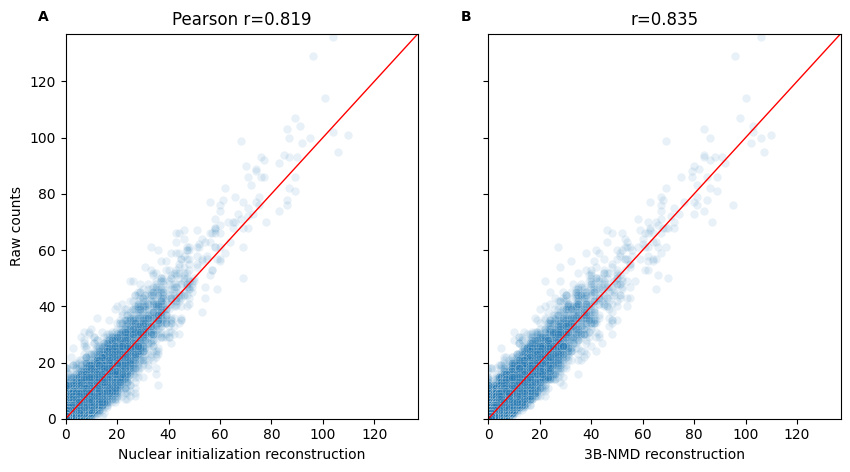

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

sns.scatterplot(
    data=df_reconstruction_nuclearinit_nmd, y=layer, x="nuclear_init", alpha=0.1, ax=ax1
)
ax1.set_title(f"Pearson r={corr_orig_nuclear:.3f}")
ax1.axline(xy1=(0, 0), slope=1, linewidth=1, color="r")
ax1.set_ylim((0, max_val + 1))
ax1.set_xlim((0, max_val + 1))
ax1.set_ylabel("Raw counts")
ax1.set_xlabel("Nuclear initialization reconstruction")
trans = mtransforms.ScaledTranslation(-20 / 72, 7 / 72, fig.dpi_scale_trans)
ax1.text(
    0.0,
    1.0,
    "A",
    transform=ax1.transAxes + trans,
    fontsize="medium",
    va="bottom",
    fontweight="bold",
)

sns.scatterplot(
    data=df_reconstruction_nuclearinit_nmd, y=layer, x="3B-NMD", alpha=0.1, ax=ax2
)
ax2.set_title(f"r={corr_orig_3bnmd:.3f}")
ax2.axline(xy1=(0, 0), slope=1, linewidth=1, color="r")
# ax2.set_ylim((0, max_val))
# ax2.set_xlim((0, max_val))
ax2.set_ylabel(None)
ax2.set_xlabel("3B-NMD reconstruction")
trans = mtransforms.ScaledTranslation(-20 / 72, 7 / 72, fig.dpi_scale_trans)
ax2.text(
    0.0,
    1.0,
    "B",
    transform=ax2.transAxes + trans,
    fontsize="medium",
    va="bottom",
    fontweight="bold",
)

# plt.savefig(f"{figure_path}/reconstruction_nuclear_init_vs_3bnmd.svg", format="svg")
plt.savefig(
    f"{figure_path}/reconstruction_nuclear_init_vs_3bnmd.png", format="png", dpi=300
)
plt.show()

#### NMD embeddings: before and after fitting

Comparison of NMD embeddings before (results of nuclear initialization) and after fitting NMD

In [33]:
W0_length = len(W0[:, 0:1].flatten())
dict_histogram_W0nuclear_vs_W_nmd = {
    "dim_1": np.concatenate((W0[:, 0:1], data.obsm["X_nmd"][:, 0:1])).flatten(),
    "dim_2": np.concatenate((W0[:, 1:2], data.obsm["X_nmd"][:, 1:2])).flatten(),
    "W0_W_nmd": ["W0 (nuclear init.)"] * W0_length + ["W (3B-NMD)"] * W0_length,
}
df_histogram_W0nuclear_vs_W_nmd_r1 = pd.DataFrame.from_dict(
    dict_histogram_W0nuclear_vs_W_nmd
)

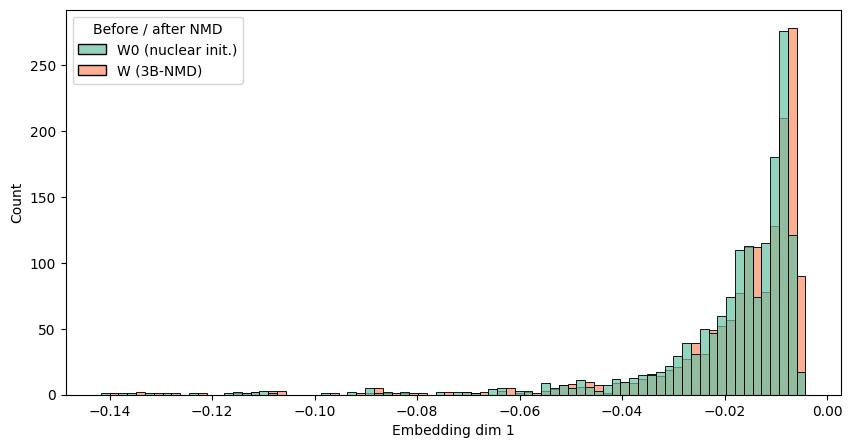

In [34]:
fig, ax = plt.subplots(figsize=(10, 5))
histogram_W0_dim1_nuclear_vs_W_nmd_r1 = sns.histplot(
    data=df_histogram_W0nuclear_vs_W_nmd_r1,
    x="dim_1",
    hue="W0_W_nmd",
    bins=80,
    alpha=0.7,
    palette="Set2",
)
histogram_W0_dim1_nuclear_vs_W_nmd_r1.legend_.set_title("Before / after NMD")
ax.set_xlabel("Embedding dim 1")

plt.savefig(f"{figure_path}/histogram_W0_dim1_nuclear_vs_W_nmd.svg", format="svg")
plt.show()

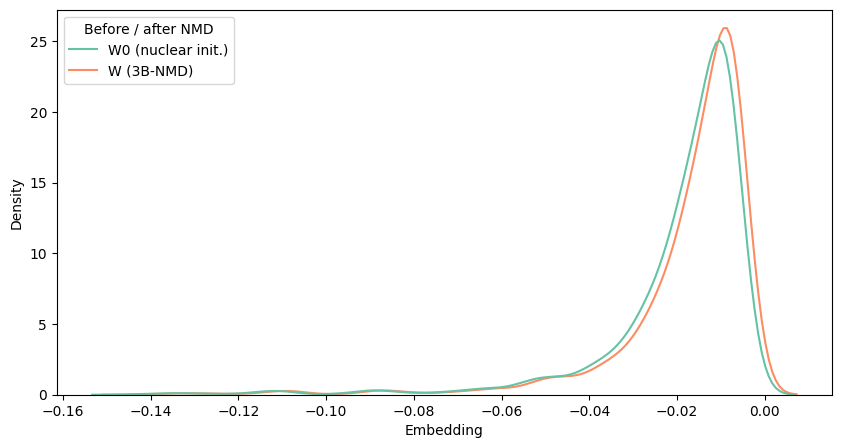

In [35]:
fig, ax = plt.subplots(figsize=(10, 5))
kdeplot_W0_dim1_nuclear_vs_W_nmd_r1 = sns.kdeplot(
    data=df_histogram_W0nuclear_vs_W_nmd_r1, x="dim_1", hue="W0_W_nmd", palette="Set2"
)
kdeplot_W0_dim1_nuclear_vs_W_nmd_r1.legend_.set_title("Before / after NMD")
ax.set_xlabel("Embedding")

plt.savefig(f"{figure_path}/kdeplot_W0_dim1_nuclear_vs_W_nmd.svg", format="svg")
plt.show()

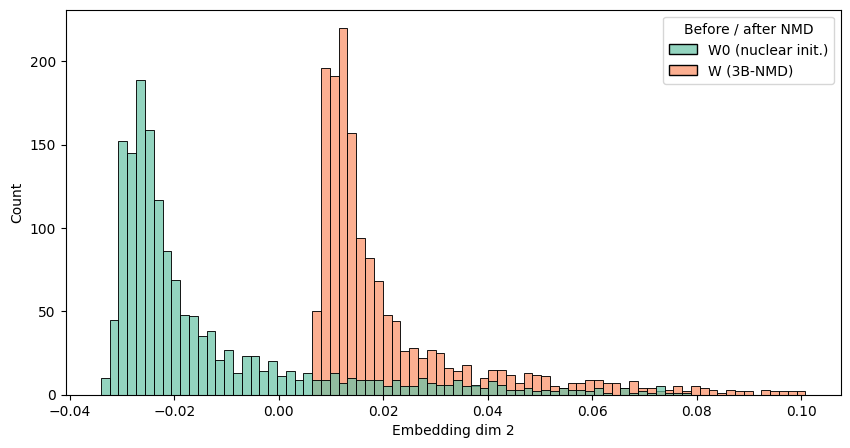

In [37]:
fig, ax = plt.subplots(figsize=(10, 5))
histogram_W0_dim2_nuclear_vs_W_nmd_r1 = sns.histplot(
    data=df_histogram_W0nuclear_vs_W_nmd_r1,
    x="dim_2",
    hue="W0_W_nmd",
    bins=80,
    alpha=0.7,
    palette="Set2",
)
histogram_W0_dim2_nuclear_vs_W_nmd_r1.legend_.set_title("Before / after NMD")
ax.set_xlabel("Embedding dim 2")

plt.savefig(f"{figure_path}/histogram_W0_dim2_nuclear_vs_W_nmd.svg", format="svg")
plt.show()

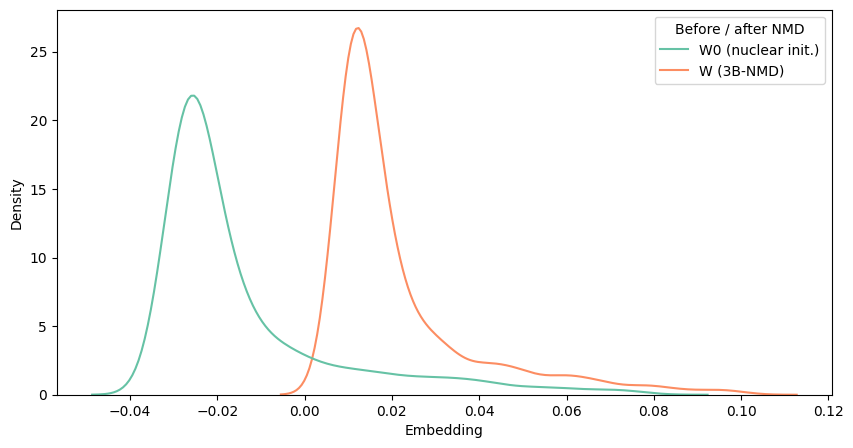

In [38]:
fig, ax = plt.subplots(figsize=(10, 5))
kdeplot_W0_dim2_nuclear_vs_W_nmd_r1 = sns.kdeplot(
    data=df_histogram_W0nuclear_vs_W_nmd_r1, x="dim_2", hue="W0_W_nmd", palette="Set2"
)
kdeplot_W0_dim2_nuclear_vs_W_nmd_r1.legend_.set_title("Before / after NMD")
ax.set_xlabel("Embedding")

plt.savefig(f"{figure_path}/kdeplot_W0_dim2_nuclear_vs_W_nmd.svg", format="svg")
plt.show()

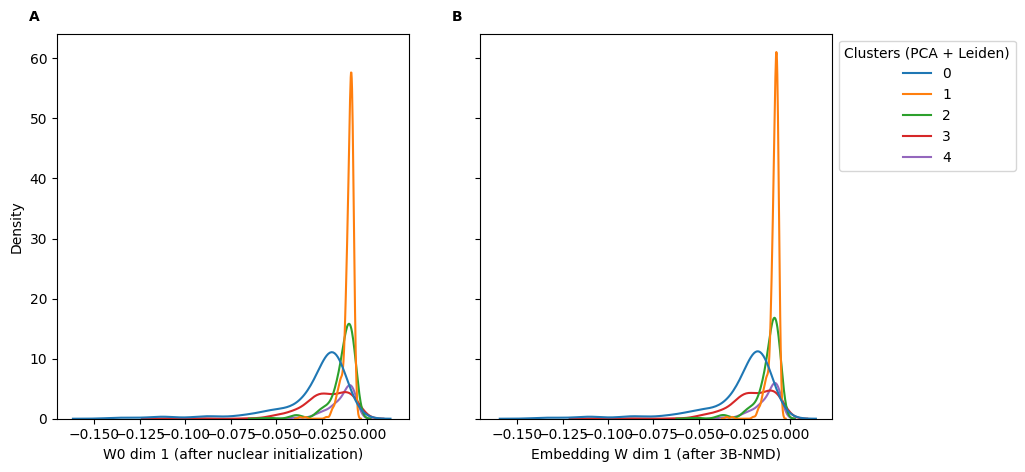

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=[10, 5])
sns.kdeplot(
    x=W0[:, 0:1].flatten(), hue=data.obs["leiden_opt_PCA"], ax=ax1, legend=False
)
ax1.set_xlabel("W0 dim 1 (after nuclear initialization)")
trans = mtransforms.ScaledTranslation(-20 / 72, 7 / 72, fig.dpi_scale_trans)
ax1.text(
    0.0,
    1.0,
    "A",
    transform=ax1.transAxes + trans,
    fontsize="medium",
    va="bottom",
    fontweight="bold",
)

sns.kdeplot(
    x=data.obsm["X_nmd"][:, 0:1].flatten(), hue=data.obs["leiden_opt_PCA"], ax=ax2
).axes.legend_.set_title("Clusters (PCA + Leiden)")
ax2.set_xlabel("Embedding W dim 1 (after 3B-NMD)")
ax2.text(
    0.0,
    1.0,
    "B",
    transform=ax2.transAxes + trans,
    fontsize="medium",
    va="bottom",
    fontweight="bold",
)
sns.move_legend(ax2, "upper left", bbox_to_anchor=(1, 1))


plt.savefig(
    f"{figure_path}/kde_W0_dim1_nuclear_vs_W_nmd_by_pca_cluster.svg", format="svg"
)
plt.show()

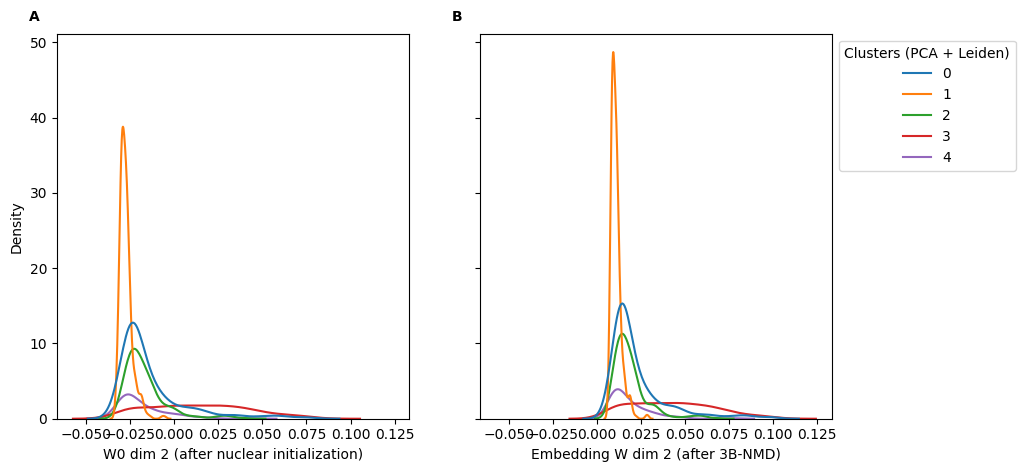

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=[10, 5])
sns.kdeplot(
    x=W0[:, 1:2].flatten(), hue=data.obs["leiden_opt_PCA"], ax=ax1, legend=False
)
ax1.set_xlabel("W0 dim 2 (after nuclear initialization)")
trans = mtransforms.ScaledTranslation(-20 / 72, 7 / 72, fig.dpi_scale_trans)
ax1.text(
    0.0,
    1.0,
    "A",
    transform=ax1.transAxes + trans,
    fontsize="medium",
    va="bottom",
    fontweight="bold",
)

sns.kdeplot(
    x=data.obsm["X_nmd"][:, 1:2].flatten(), hue=data.obs["leiden_opt_PCA"], ax=ax2
).axes.legend_.set_title("Clusters (PCA + Leiden)")
ax2.set_xlabel("Embedding W dim 2 (after 3B-NMD)")
ax2.text(
    0.0,
    1.0,
    "B",
    transform=ax2.transAxes + trans,
    fontsize="medium",
    va="bottom",
    fontweight="bold",
)
sns.move_legend(ax2, "upper left", bbox_to_anchor=(1, 1))

plt.savefig(
    f"{figure_path}/kde_W0_dim2_nuclear_vs_W_nmd_by_pca_cluster.svg", format="svg"
)
plt.show()

#### NMD embeddings vs. sequencing depth

Plot embeddings colored by sequencing depth.

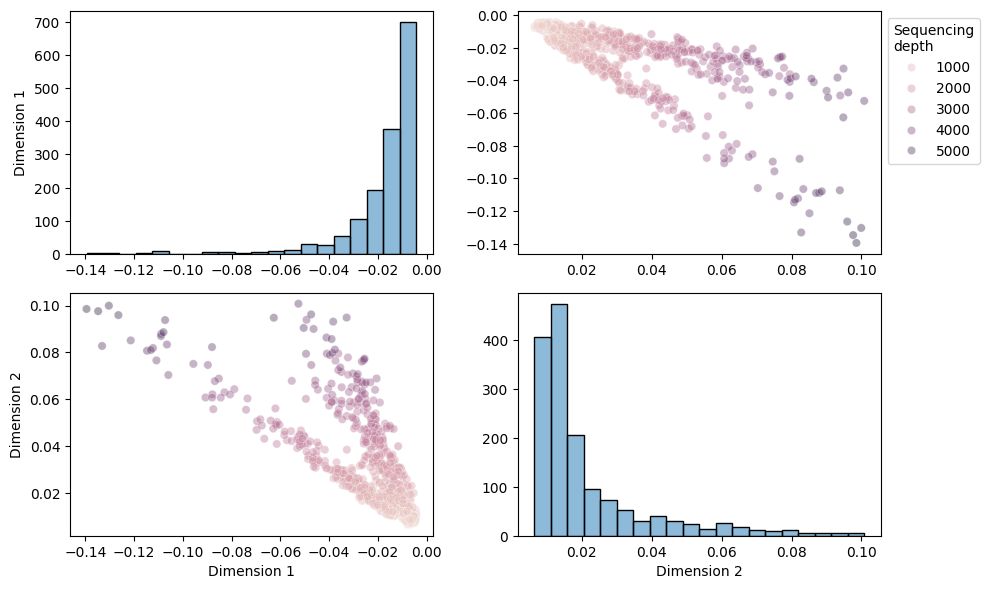

In [17]:
embeddings_2_plot = data.obsm["X_nmd"]
_, p = embeddings_2_plot.shape

fig, axs = plt.subplots(p, p, figsize=[10, 6], sharex=False)

hist_y_lim = [0, 250]
hist_bins = 20

scatter_lim = [embeddings_2_plot.min() - 0.01, embeddings_2_plot.max() + 0.01]
scatter_alpha = 0.4
scatter_hue = data.obs["total_counts"]

for i, row in enumerate(axs):
    for j, axis in enumerate(row):
        if i == j:  # histogram
            sns.histplot(
                embeddings_2_plot[:, i : (i + 1)], ax=axis, legend=False, bins=hist_bins
            )
        else:
            use_legend = (i == 0 and j == (p - 1)) and (scatter_hue is not None)
            sns.scatterplot(
                y=embeddings_2_plot[:, i : (i + 1)].flatten(),
                x=embeddings_2_plot[:, j : (j + 1)].flatten(),
                alpha=scatter_alpha,
                hue=scatter_hue,
                ax=axis,
                legend=use_legend,
            )
            if use_legend:
                sns.move_legend(axis, "upper left", bbox_to_anchor=(1, 1))
                axis.legend_.set_title("Sequencing\ndepth")
        if j == 0:
            axis.set_ylabel(f"Dimension {i + 1}")
        else:
            axis.set_ylabel(None)
        if i == len(row) - 1:
            axis.set_xlabel(f"Dimension {j + 1}")
        else:
            axis.set_xlabel(None)

plt.tight_layout()
plt.savefig(f"{figure_path}/embedding_plot_nmd_count_r2_hueSeqDepth.svg", format="svg")
plt.show()

Embeddings dimensions (separately) vs. sequencing depth.

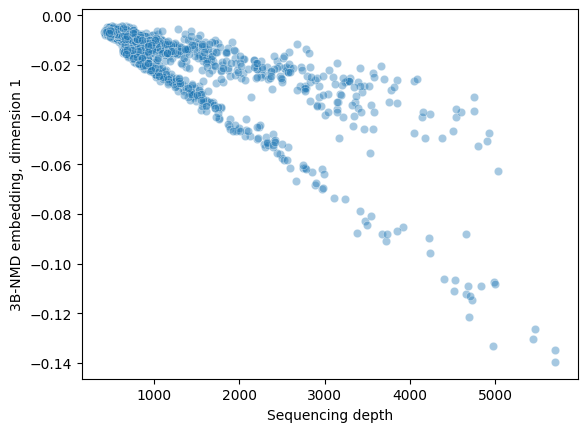

In [18]:
scatter_seqdepth_nmd_dim1 = sns.scatterplot(
    y=data.obsm["X_nmd"][:, 0:1].flatten(), x=data.obs["total_counts"], alpha=0.4
)
plt.ylabel("3B-NMD embedding, dimension 1")
plt.xlabel("Sequencing depth")


plt.savefig(f"{figure_path}/scatter_seqdepth_nmd_dim1.svg", format="svg")
plt.show()

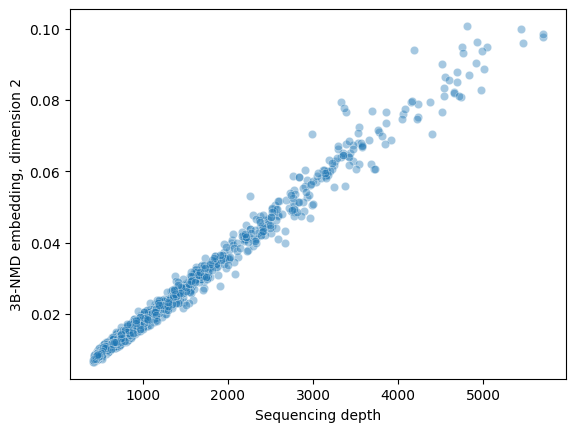

In [19]:
scatter_seqdepth_nmd_dim2 = sns.scatterplot(
    y=data.obsm["X_nmd"][:, 1:2].flatten(), x=data.obs["total_counts"], alpha=0.4
)
plt.ylabel("3B-NMD embedding, dimension 2")
plt.xlabel("Sequencing depth")


plt.savefig(f"{figure_path}/scatter_seqdepth_nmd_dim2.svg", format="svg")
plt.show()

In [20]:
corr_dim2_seqdepth = np.corrcoef(
    data.obsm["X_nmd"][:, 1:2].flatten(), data.obs["total_counts"]
)[0][1]

print(
    f"Correlation between embedding dim 2 and sequencing depth: {corr_dim2_seqdepth:.3f}"
)

Correlation between embedding dim 2 and sequencing depth: 0.994


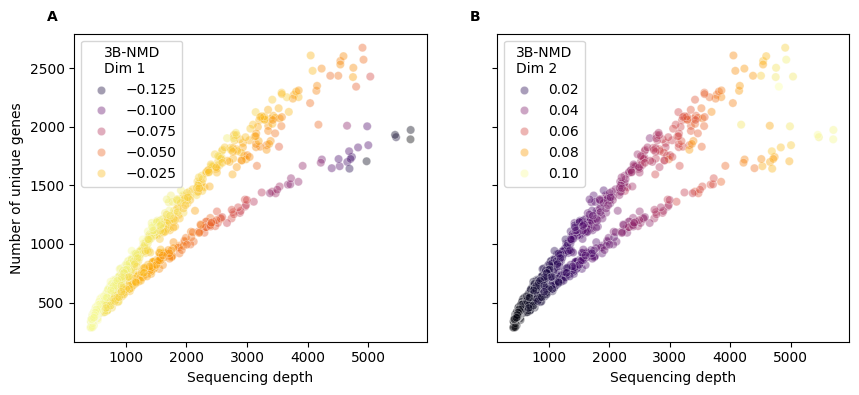

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[10, 4], sharex=True, sharey=True)
sns.scatterplot(
    x=data.obs["total_counts"],
    y=data.obs["n_genes_by_counts"],
    hue=data.obsm["X_nmd"][:, :1].flatten(),
    alpha=0.4,
    palette="inferno",
    ax=ax1,
)
ax1.set_ylabel("Number of unique genes")
ax1.set_xlabel("Sequencing depth")
ax1.legend_.set_title("3B-NMD\nDim 1")
trans = mtransforms.ScaledTranslation(-20 / 72, 7 / 72, fig.dpi_scale_trans)
ax1.text(
    0.0,
    1.0,
    "A",
    transform=ax1.transAxes + trans,
    fontsize="medium",
    va="bottom",
    fontweight="bold",
)

sns.scatterplot(
    x=data.obs["total_counts"],
    y=data.obs["n_genes_by_counts"],
    hue=data.obsm["X_nmd"][:, 1:2].flatten(),
    alpha=0.4,
    palette="inferno",
    ax=ax2,
)
ax2.set_ylabel(None)
ax2.set_xlabel("Sequencing depth")
ax2.legend_.set_title("3B-NMD\nDim 2")
ax2.text(
    0.0,
    1.0,
    "B",
    transform=ax2.transAxes + trans,
    fontsize="medium",
    va="bottom",
    fontweight="bold",
)
plt.savefig(f"{figure_path}/sequencingdepth_uniquegenes_hueNMD.svg", format="svg")
plt.show()

#### NMD "components" vs. mean counts

NMD "components" are `p x k`, where `p` is the number of columns in the original data and `k` is the number of NMD latent dimensions.

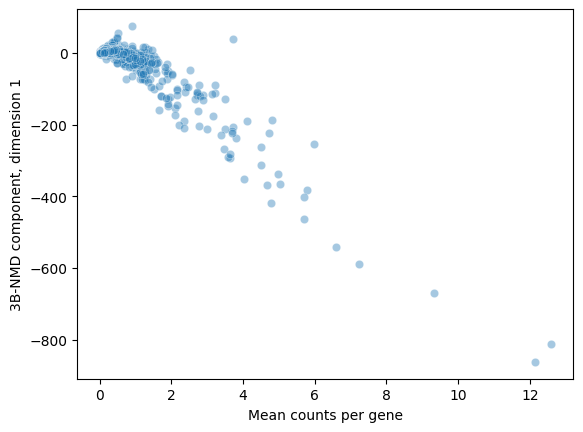

In [22]:
scatter_seqdepth_nmd_dim1 = sns.scatterplot(
    y=data.varm["nmd_components"][:, 0:1].flatten(),
    x=data.var["mean_counts"],
    alpha=0.4,
)
plt.ylabel("3B-NMD component, dimension 1")
plt.xlabel("Mean counts per gene")


plt.savefig(f"{figure_path}/scatter_mean_counts_nmd_comp1.svg", format="svg")
plt.show()

In [23]:
corr_comp2_meancountspergene = np.corrcoef(
    data.varm["nmd_components"][:, 0:1].flatten(), data.var["mean_counts"]
)[0][1]

print(
    f"Correlation between embedding component 1 and mean counts per gene: {corr_comp2_meancountspergene:.3f}"
)

Correlation between embedding component 1 and mean counts per gene: -0.894


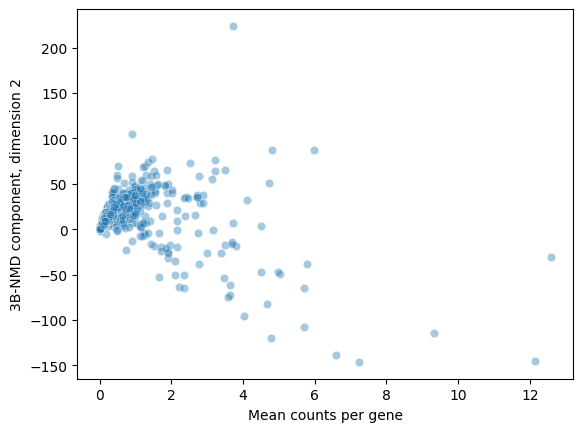

In [24]:
scatter_seqdepth_nmd_dim1 = sns.scatterplot(
    y=data.varm["nmd_components"][:, 1:2].flatten(),
    x=data.var["mean_counts"],
    alpha=0.4,
)
plt.ylabel("3B-NMD component, dimension 2")
plt.xlabel("Mean counts per gene")


plt.savefig(f"{figure_path}/scatter_mean_counts_nmd_comp2.svg", format="svg")
plt.show()

#### NMD embeddings vs. PCs

Colored by clustering found using PCA + Leiden

KeyError: 'leiden_opt_PCA'

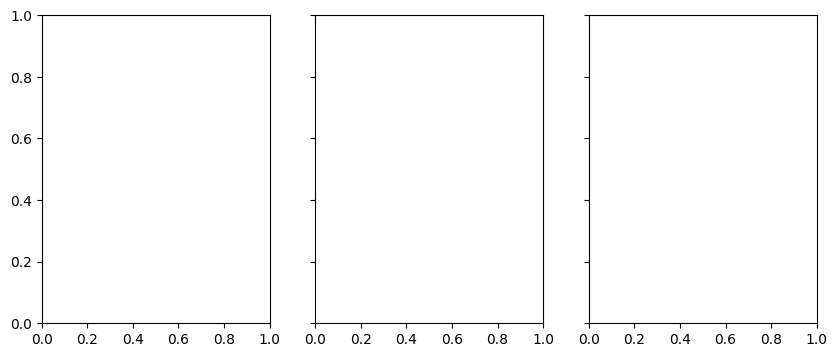

In [66]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[10, 4], sharex=True, sharey=True)
sns.scatterplot(
    y=data.obsm["X_nmd"][:, 0:1].flatten(),
    x=data.obsm["X_pca"][:, 0:1].flatten(),
    alpha=0.3,
    hue=data.obs["leiden_opt_PCA"],
    ax=ax1,
)
ax1.set_xlabel("PC, dim 1")
ax1.set_ylabel("NMD embedding dim 1")
ax1.legend_.set_title("PCA\n+Leiden")

sns.scatterplot(
    y=data.obsm["X_nmd"][:, 0:1].flatten(),
    x=data.obsm["X_pca"][:, 1:2].flatten(),
    alpha=0.3,
    hue=data.obs["leiden_opt_PCA"],
    ax=ax2,
)
ax2.set_xlabel("PC, dim 2")
ax2.legend_.set_visible(None)

sns.scatterplot(
    y=data.obsm["X_nmd"][:, 0:1].flatten(),
    x=data.obsm["X_pca"][:, 2:3].flatten(),
    alpha=0.3,
    hue=data.obs["leiden_opt_PCA"],
    ax=ax3,
)
ax3.set_xlabel("PC, dim 3")
ax3.legend_.set_visible(None)

plt.show()

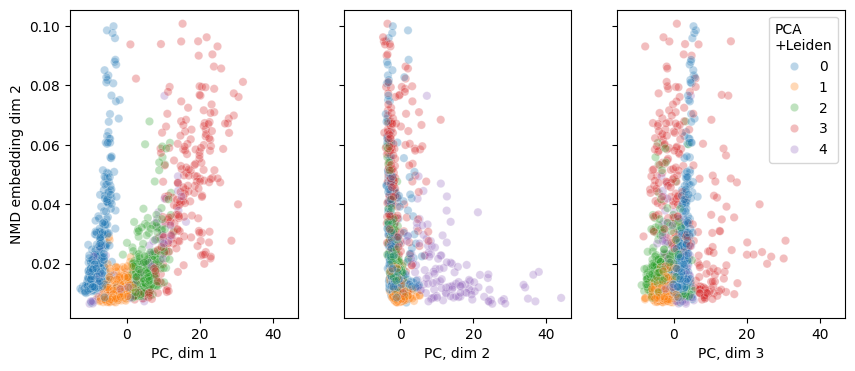

In [68]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[10, 4], sharex=True, sharey=True)
sns.scatterplot(
    y=data.obsm["X_nmd"][:, 1:2].flatten(),
    x=data.obsm["X_pca"][:, 0:1].flatten(),
    alpha=0.3,
    hue=data.obs["leiden_opt_PCA"],
    ax=ax1,
)
ax1.set_xlabel("PC, dim 1")
ax1.set_ylabel("NMD embedding dim 2")
ax1.legend_.set_visible(None)

sns.scatterplot(
    y=data.obsm["X_nmd"][:, 1:2].flatten(),
    x=data.obsm["X_pca"][:, 1:2].flatten(),
    alpha=0.3,
    hue=data.obs["leiden_opt_PCA"],
    ax=ax2,
)
ax2.set_xlabel("PC, dim 2")
ax2.legend_.set_visible(None)

sns.scatterplot(
    y=data.obsm["X_nmd"][:, 1:2].flatten(),
    x=data.obsm["X_pca"][:, 2:3].flatten(),
    alpha=0.3,
    hue=data.obs["leiden_opt_PCA"],
    ax=ax3,
)
ax3.set_xlabel("PC, dim 3")
ax3.legend_.set_title("PCA\n+Leiden")

plt.show()

#### NMD embeddings vs. PCA + Leiden clustering

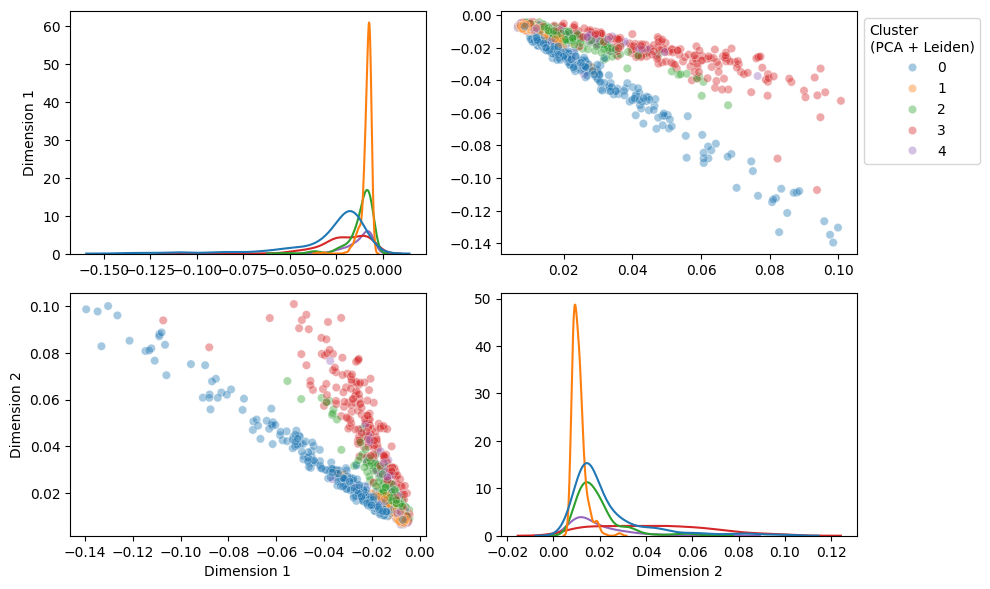

In [70]:
embeddings_2_plot = data.obsm["X_nmd"]
_, p = embeddings_2_plot.shape

fig, axs = plt.subplots(p, p, figsize=[10, 6], sharex=False)

hist_y_lim = [0, 250]
hist_bins = 20

scatter_lim = [embeddings_2_plot.min() - 0.01, embeddings_2_plot.max() + 0.01]
scatter_alpha = 0.4

scatter_hue = data.obs["leiden_opt_PCA"]


for i, row in enumerate(axs):
    for j, axis in enumerate(row):
        if i == j:
            sns.kdeplot(
                x=embeddings_2_plot[:, i : (i + 1)].flatten(),
                ax=axis,
                legend=False,
                hue=scatter_hue,
            )
        else:
            use_legend = (i == 0 and j == (p - 1)) and (scatter_hue is not None)
            sns.scatterplot(
                y=embeddings_2_plot[:, i : (i + 1)].flatten(),
                x=embeddings_2_plot[:, j : (j + 1)].flatten(),
                alpha=scatter_alpha,
                hue=scatter_hue,
                ax=axis,
                legend=use_legend,
            )
            if use_legend:
                sns.move_legend(axis, "upper left", bbox_to_anchor=(1, 1))
                axis.legend_.set_title("Cluster\n(PCA + Leiden)")
        if j == 0:
            axis.set_ylabel(f"Dimension {i + 1}")
        else:
            axis.set_ylabel(None)
        if i == len(row) - 1:
            axis.set_xlabel(f"Dimension {j + 1}")
        else:
            axis.set_xlabel(None)

plt.tight_layout()


plt.savefig(
    f"{figure_path}/embedding_plot_nmd_count_r2_huePCACluster_kde.svg", format="svg"
)
plt.show()

## UMAP: Selection of optimal number of neighbors and optimal scale via scDEED

In [15]:
n_neighbors = [10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 150, 200, 250]
min_dists = [0.05, 0.1, 0.3, 0.5, 0.7]

In [74]:
importlib.reload(scd)

<module 'tools.scDEED' from '/Users/stffn/projects/thesis_dev/msc_thesis/application/tools/scDEED.py'>

In [53]:
n_neighbors_opt = 20
min_dist_opt = 0.1

data.uns["BacSC_params_NMD"]["n_neighbors_opt"] = n_neighbors_opt
data.uns["BacSC_params_NMD"]["min_dist_opt"] = min_dist_opt

In [75]:
(
    scdeed_result,
    rel_scores,
    null_rel_scores,
    reliabilities,
    n_neighbors_opt,
    min_dist_opt,
) = scd.scdeed_parameter_selection(
    data,
    n_neighbors,
    min_dists,
    n_pcs=k_opt,
    rng_seed=674116985,
    layer="counts",
    dim_red_method="3B-NMD",
    dim_red_params={"beta1": beta_opt},
    obsm_embedding_key="X_nmd",
    embedding_method="UMAP",
    similarity_percent=0.5,
    save_path=f"{data_path}/S3_filtered_scdeed_nmd_counts_r2",
)

calculating (10, 0.05) - run 1/85


INFO:fi_nomad.entry:	Initiating run, target_rank: 2, tolerance: None
INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.5725010093301535e-05 loop took 46.374470281007234 overall (0.23187235140503618/ea)


calculating (10, 0.1) - run 2/85
calculating (10, 0.3) - run 3/85
calculating (10, 0.5) - run 4/85
calculating (10, 0.7) - run 5/85
calculating (15, 0.05) - run 6/85
calculating (15, 0.1) - run 7/85
calculating (15, 0.3) - run 8/85
calculating (15, 0.5) - run 9/85
calculating (15, 0.7) - run 10/85
calculating (20, 0.05) - run 11/85
calculating (20, 0.1) - run 12/85
calculating (20, 0.3) - run 13/85
calculating (20, 0.5) - run 14/85
calculating (20, 0.7) - run 15/85
calculating (25, 0.05) - run 16/85
calculating (25, 0.1) - run 17/85
calculating (25, 0.3) - run 18/85
calculating (25, 0.5) - run 19/85
calculating (25, 0.7) - run 20/85
calculating (30, 0.05) - run 21/85
calculating (30, 0.1) - run 22/85
calculating (30, 0.3) - run 23/85
calculating (30, 0.5) - run 24/85
calculating (30, 0.7) - run 25/85
calculating (35, 0.05) - run 26/85
calculating (35, 0.1) - run 27/85
calculating (35, 0.3) - run 28/85
calculating (35, 0.5) - run 29/85
calculating (35, 0.7) - run 30/85
calculating (40, 

Optimal number of neighbors: 20
Optimal min_dist: 0.1


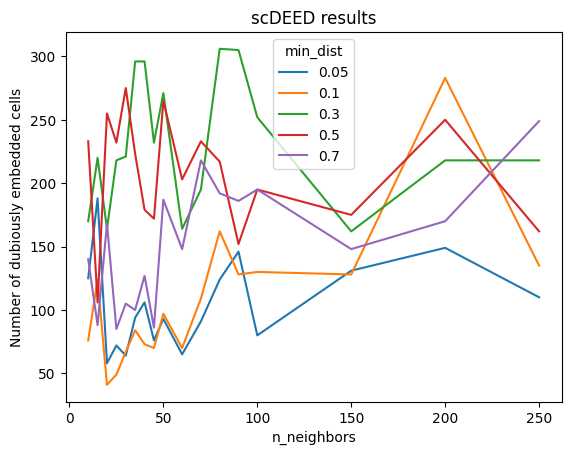

In [76]:
print(f"Optimal number of neighbors: {n_neighbors_opt}")
print(f"Optimal min_dist: {min_dist_opt}")

sns.lineplot(
    data=scdeed_result,
    x="n_neighbors",
    y="num_dubious",
    hue="min_dist",
    palette="tab10",
)
plt.title("scDEED results")
plt.ylabel("Number of dubiously embedded cells")
plt.show()

In [54]:
sc.pp.neighbors(
    data,
    n_neighbors=n_neighbors_opt,
    n_pcs=k_opt,
    key_added="NMD",
    use_rep="X_nmd",
)
sc.tl.umap(
    data,
    neighbors_key="NMD",
    min_dist=min_dist_opt,
    spread=1,
    random_state=9874516,
)

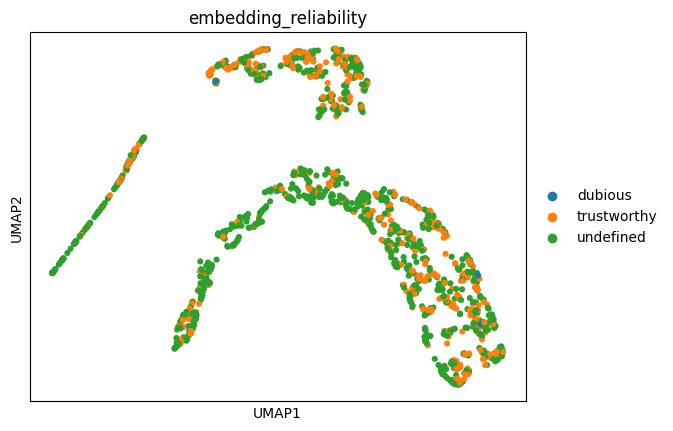

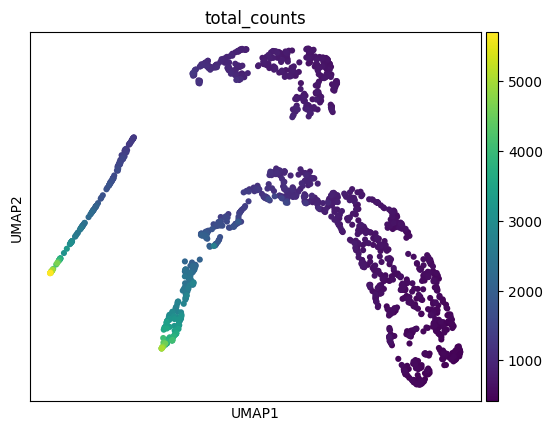

In [20]:
sc.pl.umap(
    data,
    color="embedding_reliability",
    alpha=1,
    layer="counts",
    neighbors_key="NMD",
)
plt.show()

sc.pl.umap(
    data,
    color="total_counts",
    alpha=1,
    cmap="viridis",
    layer="counts",
    neighbors_key="NMD",
)
plt.show()

## Clustering

Fit NMD on train and test data

In [17]:
X_train = ut.convert_to_dense(data_train, layer="counts")
X_train = X_train.astype(float)
m, n = X_train.shape
W0_train, H0_train = cs.nuclear_norm_init(X_train, m, n, int(k_opt))

X_test = ut.convert_to_dense(data_test, layer="counts")
X_test = X_test.astype(float)
W0_test, H0_test = cs.nuclear_norm_init(X_test, m, n, int(k_opt))

In [18]:
init_strat = InitializationStrategy.KNOWN_MATRIX
kernel_strat = KernelStrategy.MOMENTUM_3_BLOCK_MODEL_FREE

kernel_params_train = kernelInputTypes.Momentum3BlockAdditionalParameters(
    momentum_beta=beta_opt,
    candidate_factor_W0=W0_train,
    candidate_factor_H0=H0_train,
)

kernel_params_test = kernelInputTypes.Momentum3BlockAdditionalParameters(
    momentum_beta=beta_opt,
    candidate_factor_W0=W0_test,
    candidate_factor_H0=H0_test,
)

In [19]:
nmd_result_train = nmd.decompose(
    X_train,
    int(k_opt),
    kernel_strategy=kernel_strat,
    initialization=init_strat,
    kernel_params=kernel_params_train,
    manual_max_iterations=200,
    verbose=True,
    tolerance=None,
)

INFO:fi_nomad.entry:	Initiating run, target_rank: 2, tolerance: None
INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.563200152711943e-05 loop took 53.822844570997404 overall (0.26911422285498704/ea)


In [20]:
nmd_result_test = nmd.decompose(
    X_test,
    int(k_opt),
    kernel_strategy=kernel_strat,
    initialization=init_strat,
    kernel_params=kernel_params_test,
    manual_max_iterations=200,
    verbose=True,
    tolerance=None,
)

INFO:fi_nomad.entry:	Initiating run, target_rank: 2, tolerance: None
INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.5607001336757094e-05 loop took 48.386906166997505 overall (0.24193453083498753/ea)


In [21]:
data_train.obsm["X_nmd"] = nmd_result_train.factors[0]
data_test.obsm["X_nmd"] = nmd_result_test.factors[0]

data_train.varm["nmd_components"] = nmd_result_train.factors[1].T
data_test.varm["nmd_components"] = nmd_result_test.factors[1].T

data_train.layers["Theta"] = nmd_result_train.factors[0] @ nmd_result_train.factors[1]
data_test.layers["Theta"] = nmd_result_test.factors[0] @ nmd_result_test.factors[1]

In [29]:
sc.pp.neighbors(
    data_train,
    n_neighbors=n_neighbors_opt,
    n_pcs=int(k_opt),
    use_rep="X_nmd",
    key_added="NMD",
)
sc.tl.umap(
    data_train, neighbors_key="NMD", min_dist=min_dist_opt, spread=1, random_state=1234
)

sc.pp.neighbors(
    data_test,
    n_neighbors=n_neighbors_opt,
    n_pcs=int(k_opt),
    use_rep="X_nmd",
    key_added="NMD",
)
sc.tl.umap(
    data_test, neighbors_key="NMD", min_dist=min_dist_opt, spread=1, random_state=1234
)

In [30]:
theta_opt, mirror_opt, umap_2_opt, ssd = ut.find_opt_umap_rotation(
    data_train.obsm["X_umap"].copy(), data_test.obsm["X_umap"].copy()
)
data_test.obsm["X_umap_rotated"] = umap_2_opt

In [31]:
res_min = 0.01
res_max = 0.5
res_step = 0.02
resolutions = np.round(np.arange(res_min, res_max, res_step), 2)

In [39]:
importlib.reload(co)

<module 'tools.clustering_opt' from '/Users/stffn/projects/thesis_dev/msc_thesis/application/tools/clustering_opt.py'>

In [40]:
co.cluster_train_test(
    data_train,
    data_test,
    resolutions,
    alg="leiden",
    neighbors_key="NMD",
    random_state=786469,
)

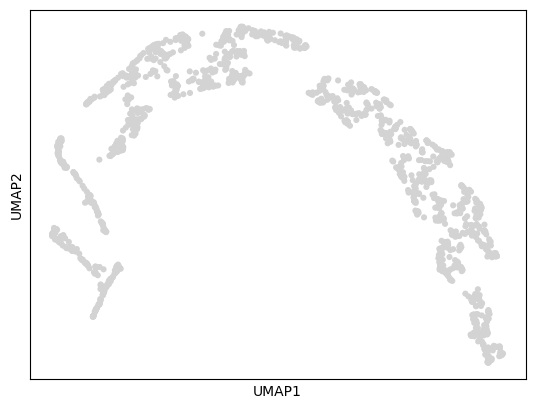

In [42]:
sc.pl.umap(data_train, neighbors_key="NMD")

In [55]:
res_opt = 0.03

In [56]:
data.uns["BacSC_params_NMD"]["res_opt"] = n_neighbors_opt

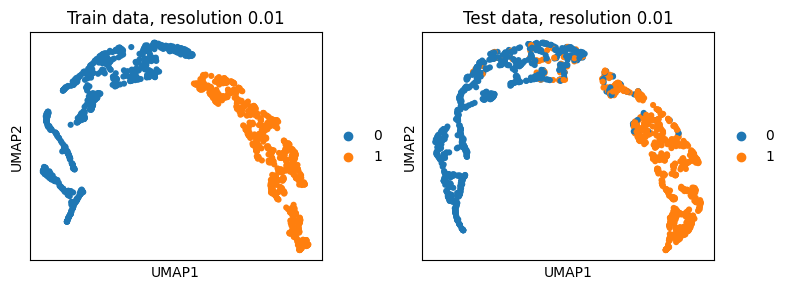

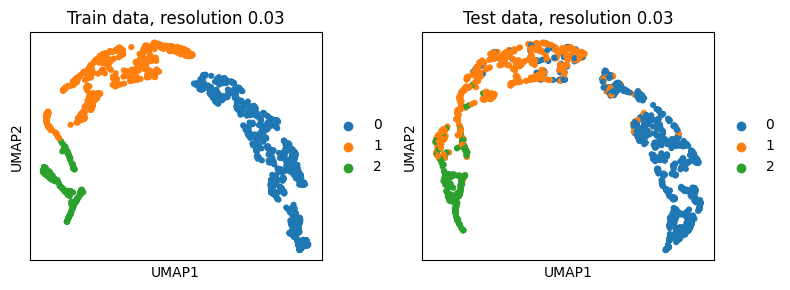

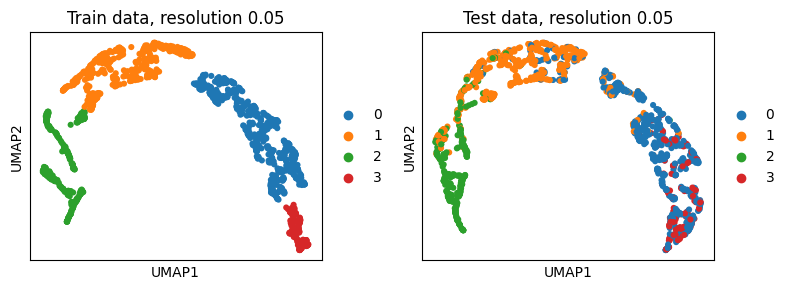

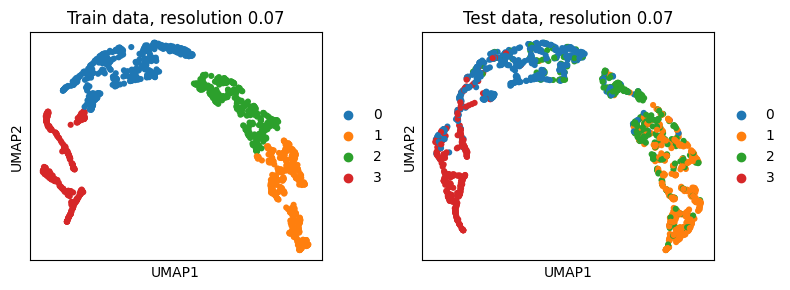

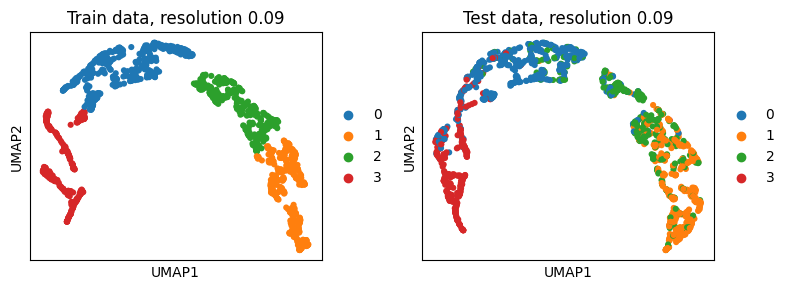

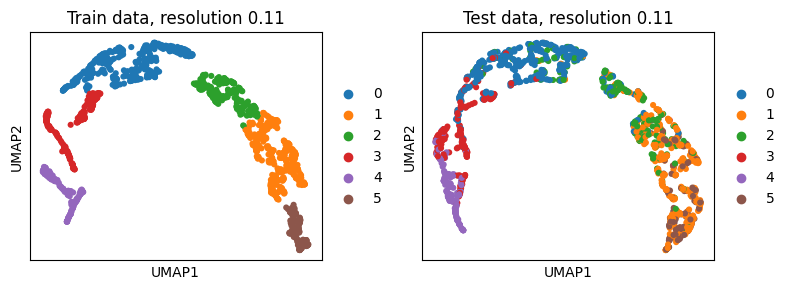

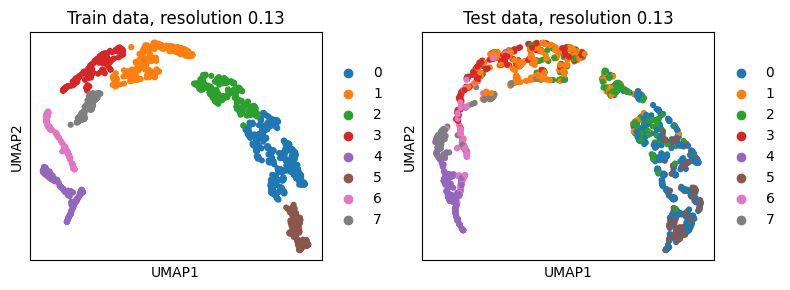

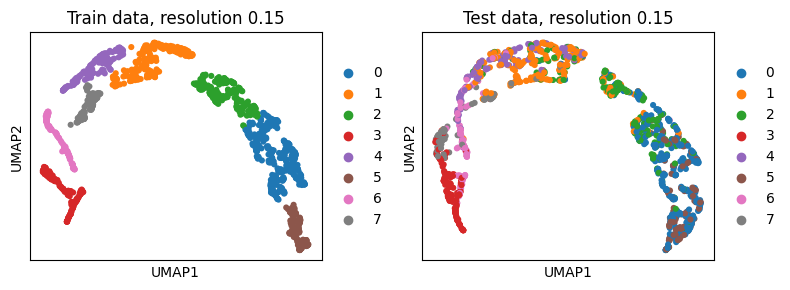

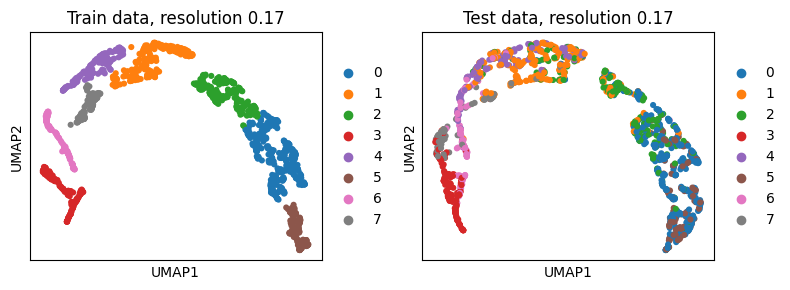

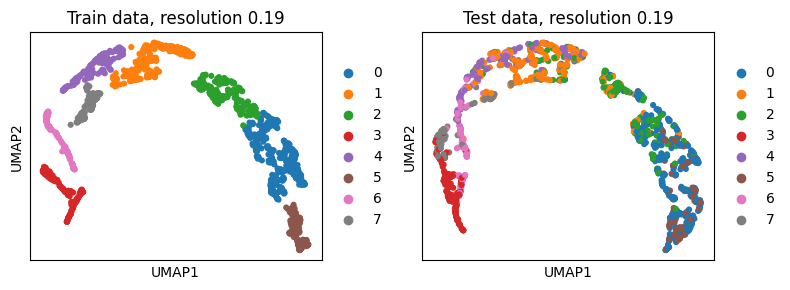

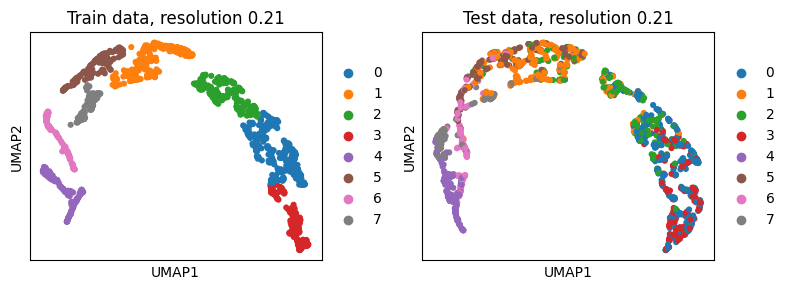

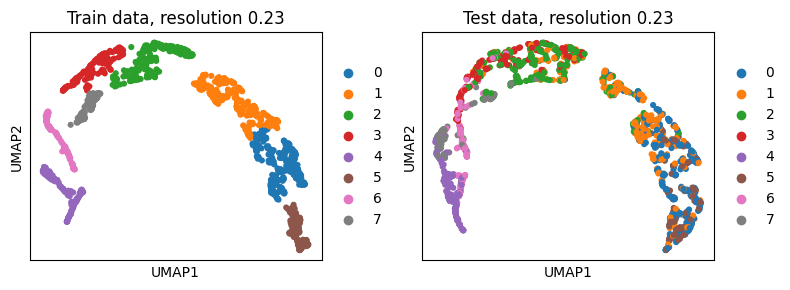

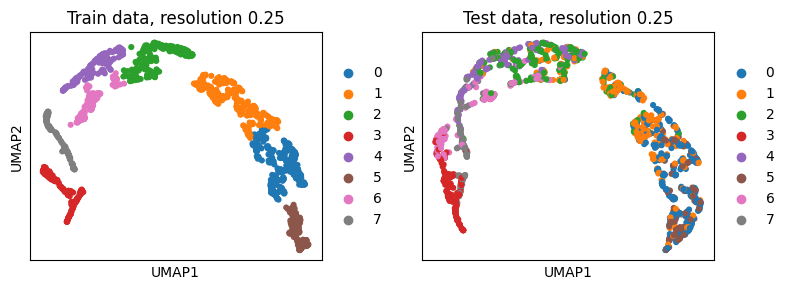

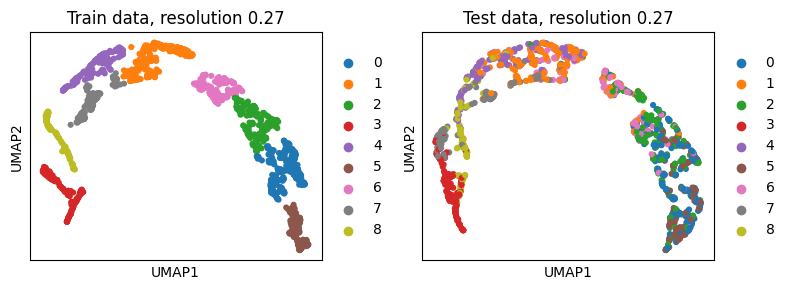

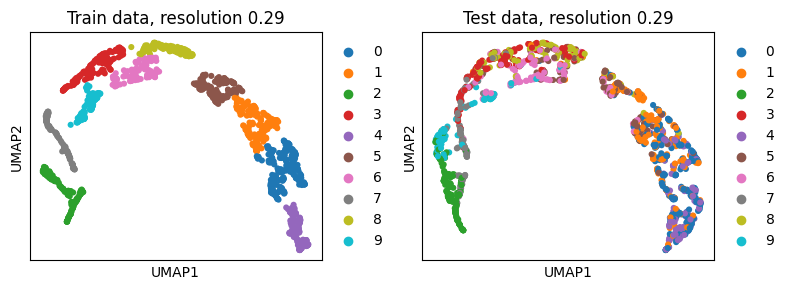

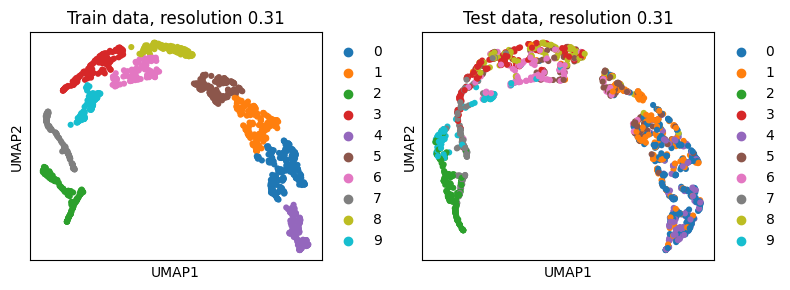

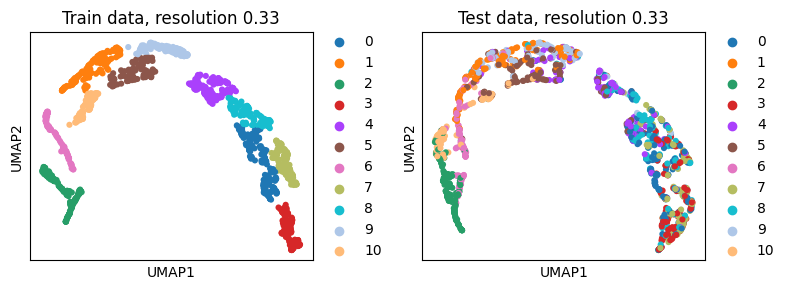

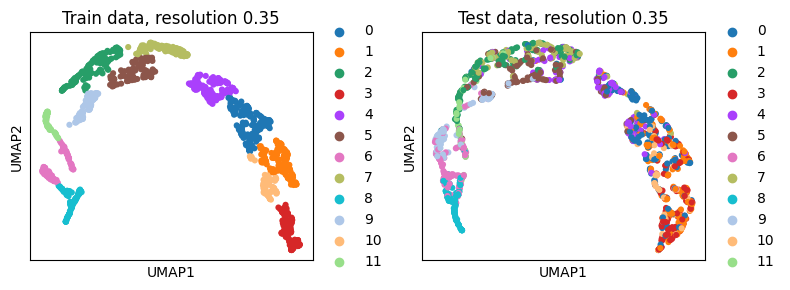

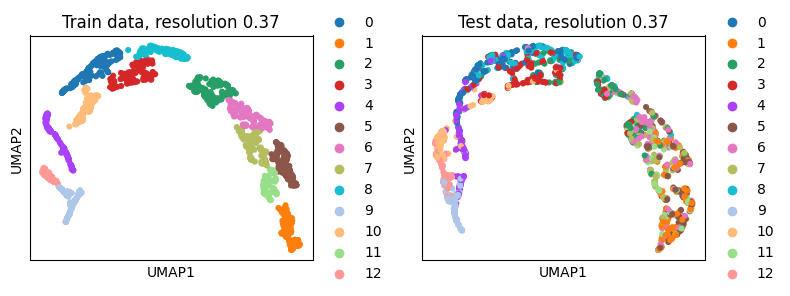

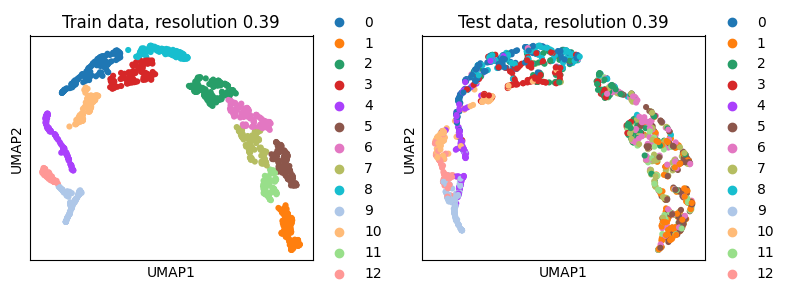

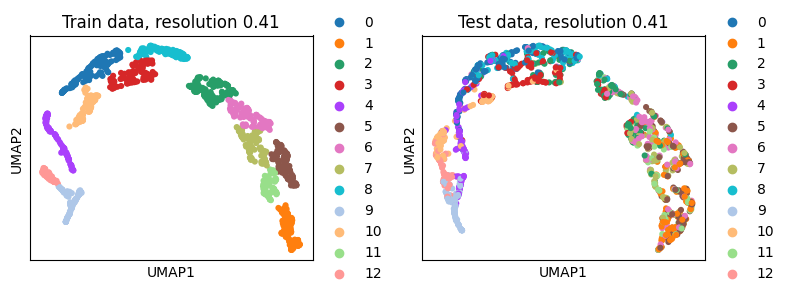

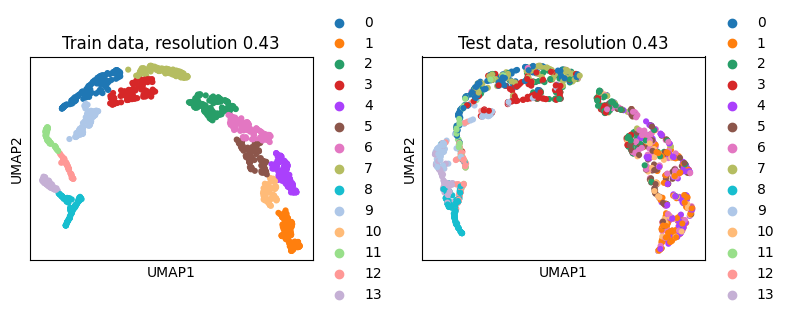

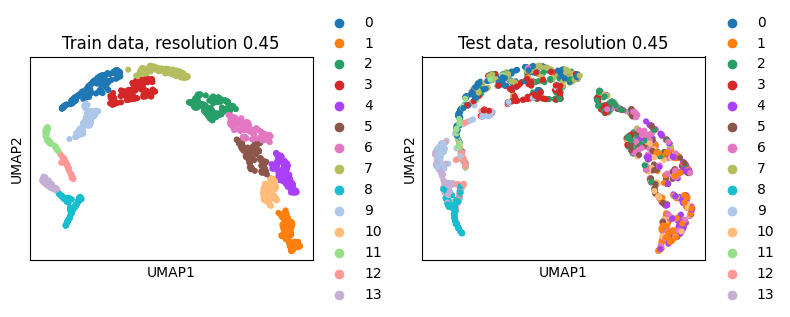

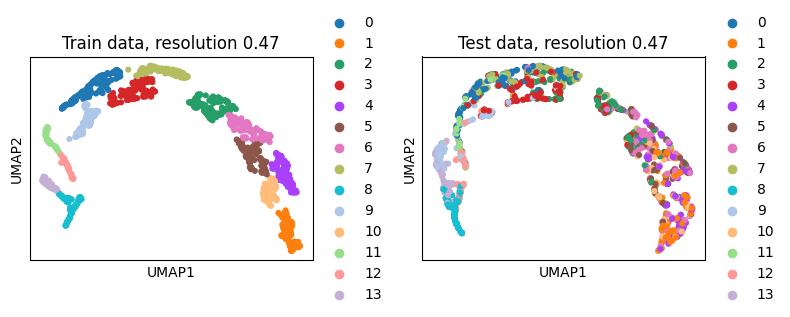

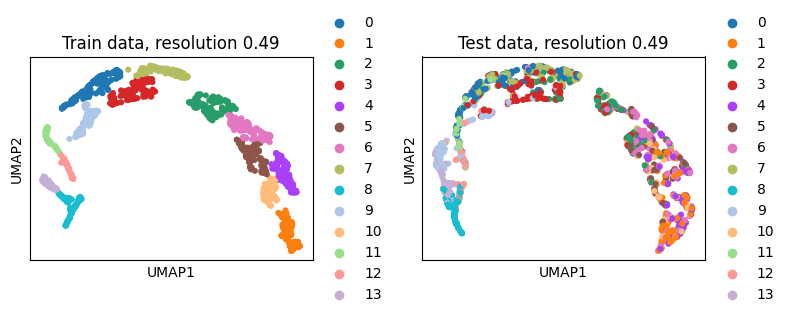

In [43]:
for resolution in resolutions:
    fig, ax = plt.subplots(1, 2, figsize=(8, 3))
    sc.pl.umap(
        data_train,
        color=f"NMD_leiden_res{resolution}",
        ax=ax[0],
        title=f"Train data, resolution {resolution}",
        show=False,
        neighbors_key="NMD",
    )
    sc.pl.embedding(
        data_test,
        basis="X_umap_rotated",
        color=f"NMD_leiden_res{resolution}",
        ax=ax[1],
        title=f"Test data, resolution {resolution}",
        show=False,
        neighbors_key="NMD",
    )
    ax[1].set_xlabel("UMAP1")
    ax[1].set_ylabel("UMAP2")
    plt.tight_layout()
    plt.show()

In [45]:
importlib.reload(co)
mod_df, mod_df_wide, res_opt = co.find_optimal_clustering_resolution(
    data_train, data_test, resolutions, res_key="NMD_leiden_res", neighbors_key="NMD"
)

print(f"Optimal resolution {res_opt}")

resolution: 0.01 - clusters: 2 - Train: 0.491 - Test: 0.435 - Random: 0.248
resolution: 0.03 - clusters: 3 - Train: 0.482 - Test: 0.402 - Random: 0.186
resolution: 0.05 - clusters: 4 - Train: 0.474 - Test: 0.321 - Random: 0.133
resolution: 0.07 - clusters: 4 - Train: 0.469 - Test: 0.314 - Random: 0.11
resolution: 0.09 - clusters: 4 - Train: 0.464 - Test: 0.309 - Random: 0.1
resolution: 0.11 - clusters: 6 - Train: 0.459 - Test: 0.258 - Random: 0.074
resolution: 0.13 - clusters: 8 - Train: 0.457 - Test: 0.222 - Random: 0.052
resolution: 0.15 - clusters: 8 - Train: 0.453 - Test: 0.219 - Random: 0.051
resolution: 0.17 - clusters: 8 - Train: 0.45 - Test: 0.216 - Random: 0.048
resolution: 0.19 - clusters: 8 - Train: 0.447 - Test: 0.213 - Random: 0.045
resolution: 0.21 - clusters: 8 - Train: 0.445 - Test: 0.205 - Random: 0.04
resolution: 0.23 - clusters: 8 - Train: 0.442 - Test: 0.202 - Random: 0.037
resolution: 0.25 - clusters: 8 - Train: 0.439 - Test: 0.199 - Random: 0.036
resolution: 0.27 

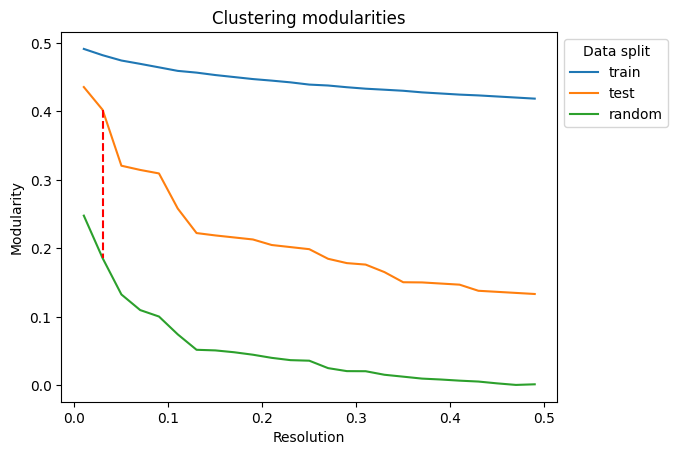

In [47]:
fig, ax = plt.subplots()
sns.lineplot(data=mod_df, x="resolution", y="score", hue="type")
ax.set(title="Clustering modularities", xlabel="Resolution", ylabel="Modularity")

ax.plot(
    [res_opt, res_opt],
    [
        mod_df[(mod_df["resolution"] == res_opt) & (mod_df["type"] == "test")]["score"],
        mod_df[(mod_df["resolution"] == res_opt) & (mod_df["type"] == "random")][
            "score"
        ],
    ],
    linestyle="dashed",
    color="red",
)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.legend_.set_title("Data split")

plt.savefig(f"{figure_path}/modularities_plot_nmd_NMDCluster.svg", format="svg")
plt.show()

In [57]:
sc.pp.neighbors(
    data,
    n_neighbors=n_neighbors_opt,
    n_pcs=int(k_opt),
    use_rep="X_nmd",
    key_added="NMD",
)

In [58]:
sc.tl.leiden(
    data,
    resolution=res_opt,
    key_added="leiden_opt_NMD",
    neighbors_key="NMD",
)

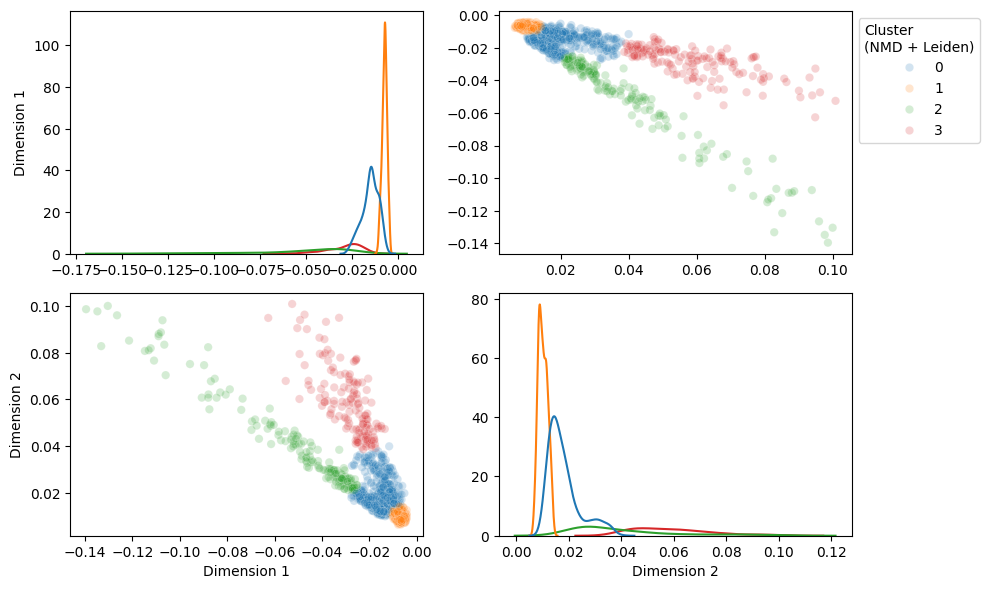

In [40]:
embeddings_2_plot = data.obsm["X_nmd"]
_, p = embeddings_2_plot.shape

fig, axs = plt.subplots(p, p, figsize=[10, 6], sharex=False)

hist_y_lim = [0, 250]
hist_bins = 20

scatter_lim = [embeddings_2_plot.min() - 0.01, embeddings_2_plot.max() + 0.01]
scatter_alpha = 0.2

scatter_hue = data.obs["leiden_opt_NMD"]


for i, row in enumerate(axs):
    for j, axis in enumerate(row):
        if i == j:
            sns.kdeplot(
                x=embeddings_2_plot[:, i : (i + 1)].flatten(),
                ax=axis,
                legend=False,
                hue=scatter_hue,
            )
        else:
            use_legend = (i == 0 and j == (p - 1)) and (scatter_hue is not None)
            sns.scatterplot(
                y=embeddings_2_plot[:, i : (i + 1)].flatten(),
                x=embeddings_2_plot[:, j : (j + 1)].flatten(),
                alpha=scatter_alpha,
                hue=scatter_hue,
                ax=axis,
                legend=use_legend,
            )
            if use_legend:
                sns.move_legend(axis, "upper left", bbox_to_anchor=(1, 1))
                axis.legend_.set_title("Cluster\n(NMD + Leiden)")
        if j == 0:
            axis.set_ylabel(f"Dimension {i + 1}")
        else:
            axis.set_ylabel(None)
        if i == len(row) - 1:
            axis.set_xlabel(f"Dimension {j + 1}")
        else:
            axis.set_xlabel(None)

plt.tight_layout()


# plt.savefig(fig_path_rank3_norm_nmd + "embedding_plot_nmd_norm_r3_hueNMDCluster_diagKDE.svg", format="svg")
plt.show()

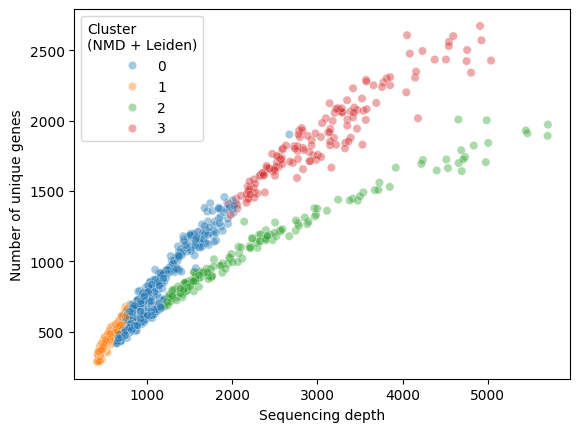

In [60]:
scatter_seqdepth_uniquegenes_hue_nmd_normr3_leidenopt = sns.scatterplot(
    x=data.obs["total_counts"],
    y=data.obs["n_genes"],
    hue=data.obs["leiden_opt_NMD"],
    alpha=0.4,
)
plt.ylabel("Number of unique genes")
plt.xlabel("Sequencing depth")
scatter_seqdepth_uniquegenes_hue_nmd_normr3_leidenopt.axes.legend_.set_title(
    "Cluster\n(NMD + Leiden)"
)

# plt.savefig(fig_path_rank3_norm_nmd + "./scatter_seqdepth_uniquegenes_hue_nmd_normr3_leidenopt.svg", format="svg")

plt.show()

In [64]:
data

AnnData object with n_obs × n_vars = 1544 × 5553
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale', 'embedding_reliability', 'reliability_score', 'null_reliability_score', 'leiden_opt', 'leiden_opt_NMD'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'is_scd_outlier', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_mean', 'nb_umi', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'mean', 'std'
    uns: 'BacSC_params_PCA', 'PCA', 'leiden', 'leiden_opt_colors', 'pca', 'umap', 'BacSC_params_NMD', 'NMD', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap', 'X_nmd'
    varm: 'PCs', 'nmd_components'
    layers: 'counts', 'vst_counts', 'Theta_nmd'
    obsp: 'PCA_connectivities', 'PCA_distances', 'NMD_distances', 'NMD_connectivities'

In [ ]:
umap_pca_leiden_opt = sc.pl.umap(
    data, color="leiden_opt_PCA", return_fig=True, palette=sns.color_palette("tab10")
)
ax = umap_pca_leiden_opt.axes[0]
ax.legend_.set_title("Clusters\n(PCA + Leiden)")
ax.set_title(None)
# plt.savefig("./pca_umap_pca_cluster.svg")
plt.show()

## Differential expression

In [61]:
sc.tl.rank_genes_groups(data, "leiden_opt_NMD", method="wilcoxon")

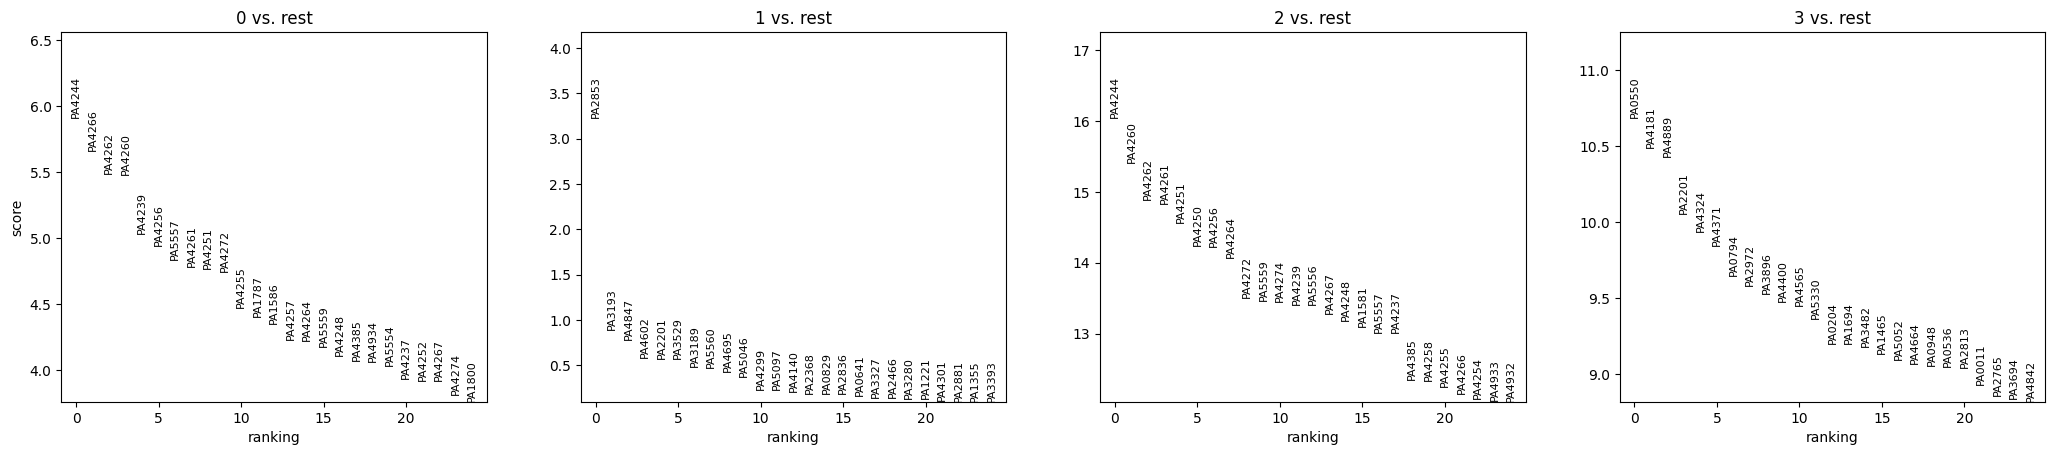

In [62]:
sc.pl.rank_genes_groups(data, n_genes=25, sharey=False)

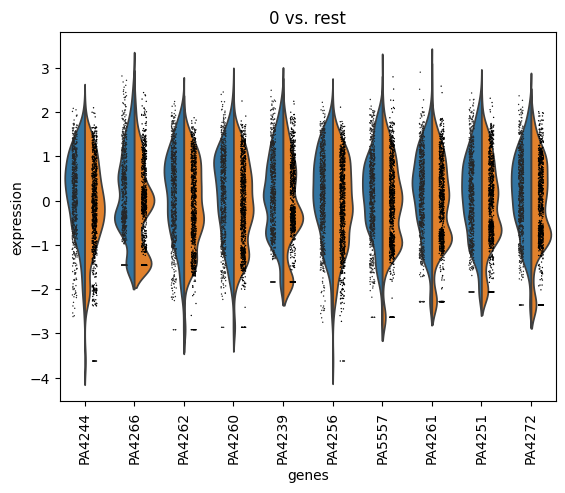

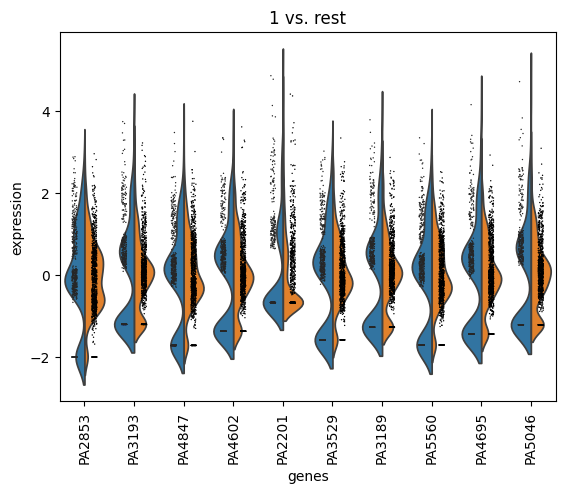

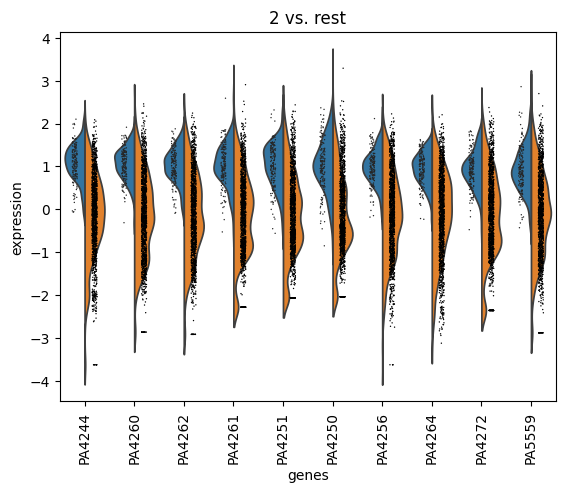

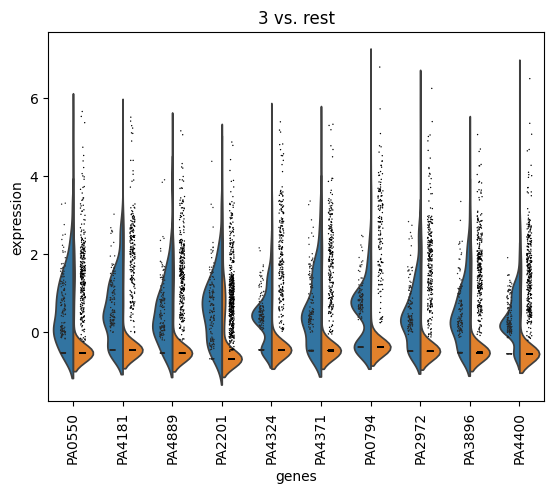

In [63]:
nclust = len(np.unique(data.obs["leiden_opt_NMD"]))

for i in range(nclust):
    sc.pl.rank_genes_groups_violin(data, groups=str(i), n_genes=10)

In [67]:
data.write(data_path + "/nmd_raw_counts.h5ad")

In [4]:
data = sc.read_h5ad(data_path + "/nmd_raw_counts.h5ad")

## Generate synthetic null data for ClusterDE

### Estimate distribution and parameters for every gene

In [6]:
nb.estimate_overdisp_nb(data, layer="counts", flavor="statsmod_auto")

gene 0
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 100
Both NB a

### Find optimal correlation matrix scaling and generate synthetic null data

In [7]:
try:
    xmin, fval, R_est_noscale = cd.select_covariance_scaling(
        data, cor_cutoff=0.1, min_scale=1, max_scale=2, maxiter=20, rng_seed=1234
    )
except:
    _, R_est_noscale = cd.generate_nb_data_copula(
        data,
        rng_seed=1234,
        nb_flavor="statsmod_auto",
        auto_dist=True,
        correct_var=True,
        return_R=True,
        corr_factor=1,
        R_est=None,
        check_pd=True,
    )
    xmin = 1
print(xmin)

Factor: 1 - Error: 329.3884189174407
Factor: 2 - Error: 348.98678379806
Factor: -0.618034 - Error: 432.57501800766005
Factor: 1 - Error: 329.3884189174407
Factor: 0.38196600897566 - Error: 424.5779139738083
Factor: 1.38196601 - Error: 316.86066839922916
Factor: 1.6180339872046798 - Error: 336.87715062628587
Factor: 1.2360679772046799 - Error: 308.89795881664656
Factor: 1.1458980338630373 - Error: 316.56975436699855
Factor: 1.2917960666583574 - Error: 311.5831370730923
Factor: 1.2016261237245467 - Error: 318.27165625929223
Factor: 1.2573542131782243 - Error: 310.23299378482466
Factor: 1.2229123598538687 - Error: 319.41446262007446
Factor: 1.244198595827413 - Error: 309.7746641836902
Factor: 1.2310429785361037 - Error: 308.7934774458891
Factor: 1.2279373585592188 - Error: 308.63644299851444
Factor: 1.2260179798534812 - Error: 308.0922619858525
Factor: 1.224831738573653 - Error: 318.7664439633101
Factor: 1.2267511172793908 - Error: 308.13491228483934
Factor: 1.2255648760049278 - Error: 31

In [8]:
# Generate scaling matrix
cor_orig = cd.schaefer_strimmer(data.layers["counts"].toarray(), use_corr=True)
factor_cor = np.abs(cor_orig) > 0.1
cf = factor_cor * xmin
cf[cf == 0] = 1
np.fill_diagonal(cf, 1)

In [9]:
importlib.reload(cd)
n, p = data.X.shape
data_null_gen, R_est = cd.generate_nb_data_copula(
    data,
    rng_seed=5678,
    nb_flavor="statsmod_auto",
    auto_dist=True,
    correct_var=True,
    return_R=True,
    new_data_shape=(2 * n, p),
    corr_factor=cf,
    R_est=R_est_noscale,
    check_pd=False,
    min_nonzero=2,
)

In [10]:
sc.pp.calculate_qc_metrics(data_null_gen)
data_null_gen.var["var_counts"] = np.asarray(np.var(data_null_gen.X, axis=0)).squeeze()
data_null_gen.var["mean_counts"] = np.asarray(
    np.mean(data_null_gen.X, axis=0)
).squeeze()

In [11]:
data_nonzero = data[:, data_null_gen.var_names].copy()

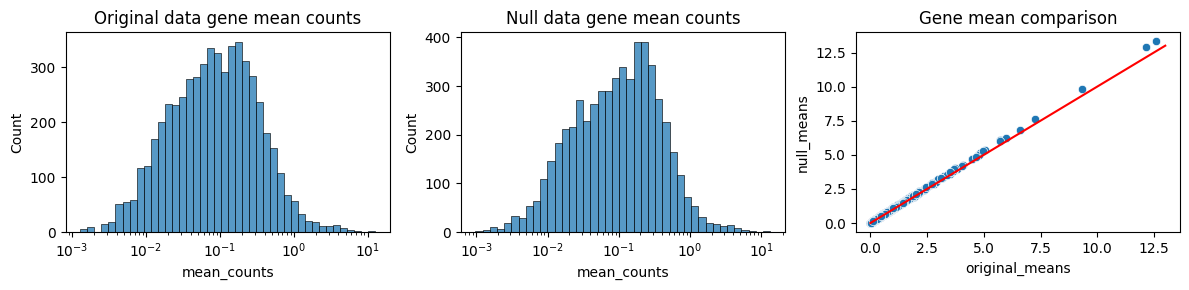

SignificanceResult(statistic=0.9982935284094521, pvalue=0.0)


In [12]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
sns.histplot(data_nonzero.var, x="mean_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene mean counts")
sns.histplot(data_null_gen.var, x="mean_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene mean counts")

mean_df_opt = pd.DataFrame(
    {
        "original_means": data_nonzero.var["mean_counts"],
        "null_means": data_null_gen.var["mean_counts"],
    }
)
sns.scatterplot(mean_df_opt, y="null_means", x="original_means", ax=ax[2])
ax[2].plot(
    [0, np.ceil(np.max(data_nonzero.var["mean_counts"]))],
    [0, np.ceil(np.max(data_nonzero.var["mean_counts"]))],
    color="red",
)
ax[2].set_title("Gene mean comparison")
plt.tight_layout()
plt.show()

print(spearmanr(mean_df_opt["original_means"], mean_df_opt["null_means"]))

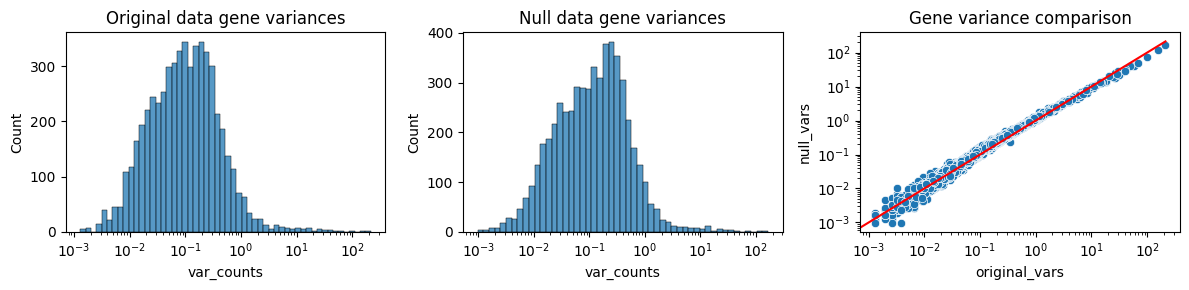

SignificanceResult(statistic=0.9971341826922944, pvalue=0.0)
[[1.         0.99745318]
 [0.99745318 1.        ]]


In [13]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
sns.histplot(data_nonzero.var, x="var_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene variances")
sns.histplot(data_null_gen.var, x="var_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene variances")

var_df_opt = pd.DataFrame(
    {
        "original_vars": data_nonzero.var["var_counts"],
        "null_vars": data_null_gen.var["var_counts"],
    }
)
var_df_opt["ratio"] = var_df_opt["null_vars"] / var_df_opt["original_vars"]
var_df_opt["diff"] = var_df_opt["null_vars"] - var_df_opt["original_vars"]

g = sns.scatterplot(var_df_opt, y="null_vars", x="original_vars", ax=ax[2])

g.set(xscale="log", yscale="log")
ax[2].plot(
    [0, np.ceil(np.max(data_nonzero.var["var_counts"]))],
    [0, np.ceil(np.max(data_nonzero.var["var_counts"]))],
    color="red",
)
ax[2].set_title("Gene variance comparison")
plt.tight_layout()
plt.show()

print(spearmanr(var_df_opt["original_vars"], var_df_opt["null_vars"]))
print(np.corrcoef(var_df_opt["original_vars"], var_df_opt["null_vars"]))

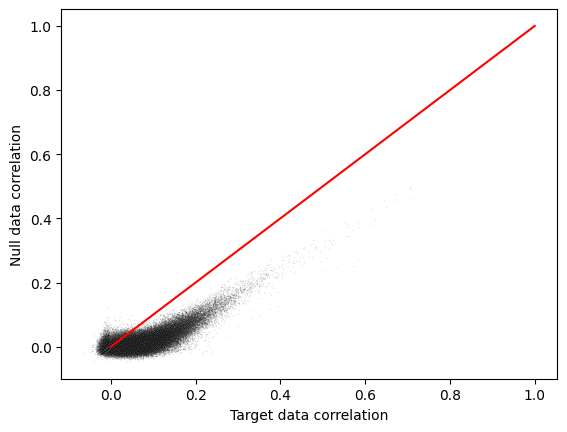

In [14]:
cor_shrink = cd.schaefer_strimmer(
    data_nonzero.layers["counts"].toarray(), use_corr=True
)
cor_shrink = pd.DataFrame(
    cor_shrink, index=data_nonzero.var_names, columns=data_nonzero.var_names
)

cor_gen_shrink = cd.schaefer_strimmer(data_null_gen.X, use_corr=True)
cor_gen_shrink = pd.DataFrame(
    cor_gen_shrink, index=data_nonzero.var_names, columns=data_nonzero.var_names
)

# Plot only 100.000 randomly sampled correlations instaed of ~30M
rng = np.random.default_rng(1234)
all_cors = pd.DataFrame(
    {
        "cor_shrink": cor_shrink.values.flatten(),
        "cor_gen_shrink": cor_gen_shrink.values.flatten(),
    }
)

ids = rng.choice(len(all_cors), 100000, replace=False)
all_cors_subset = all_cors.loc[ids]

sns.scatterplot(
    all_cors_subset[all_cors_subset["cor_shrink"] < 0.99],
    x="cor_shrink",
    y="cor_gen_shrink",
    s=1,
    color="black",
    alpha=0.1,
)
plt.plot(
    [0, np.ceil(np.max(all_cors_subset["cor_shrink"]))],
    [0, np.ceil(np.max(all_cors_subset["cor_shrink"]))],
    color="red",
)
plt.xlabel("Target data correlation")
plt.ylabel("Null data correlation")

plt.show()

### Process null data

In [15]:
sc.pp.calculate_qc_metrics(data_null_gen)
data_null_gen.var["var_counts"] = np.asarray(np.var(data_null_gen.X, axis=0)).squeeze()
data_null_gen.var["mean_counts"] = np.asarray(
    np.mean(data_null_gen.X, axis=0)
).squeeze()

In [17]:
data.uns_keys()

['BacSC_params_NMD',
 'BacSC_params_PCA',
 'NMD',
 'PCA',
 'leiden',
 'leiden_opt_colors',
 'pca',
 'rank_genes_groups',
 'umap']

In [18]:
importlib.reload(nb)
nb.estimate_overdisp_nb(data_null_gen, flavor="sctransform", seed=1234)
data_null_gen.layers["counts"] = data_null_gen.X.copy()

k_opt = data.uns["BacSC_params_PCA"]["k_opt"]
n_neighbors_opt = data.uns["BacSC_params_PCA"]["n_neighbors_opt"]
min_dist_opt = data.uns["BacSC_params_PCA"]["min_dist_opt"]
res_opt = data.uns["BacSC_params_PCA"]["res_opt"]

sc.pp.calculate_qc_metrics(
    data_null_gen, var_type="genes", percent_top=None, log1p=True, inplace=True
)
sc.pp.normalize_total(data_null_gen, target_sum=None, layer=None)
data_null_gen.X = sps.csr_matrix(
    np.log(data_null_gen.X + np.array(data_null_gen.var["nb_overdisp"] / 4))
)
data_null_gen.layers["vst_counts"] = data_null_gen.X.copy()
sc.pp.scale(data_null_gen, max_value=10, zero_center=True)
data_null_gen.X[np.isnan(data_null_gen.X)] = 0
sc.tl.pca(data_null_gen, svd_solver="arpack")
sc.pp.neighbors(data_null_gen, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_null_gen, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)

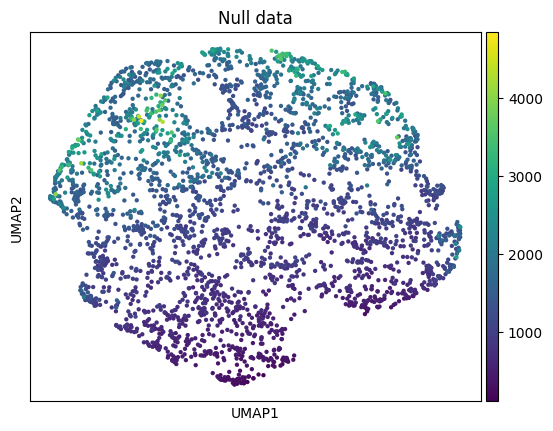

In [19]:
sc.pl.umap(
    data_null_gen, color="total_counts", alpha=1, cmap="viridis", title="Null data"
)
plt.show()

In [20]:
data_path

'../data/S3'

In [21]:
data_null_gen.write(data_path + "/outs_raw_counts" + "/null_data_opt.h5ad")

In [23]:
n_splits = 1
rng = np.random.default_rng(1234)
seeds = rng.choice(1000, n_splits)
null_pvals_dict = {}
min_pvals_null = []
c = 0
res_start = 0.01
res_step = 0.01

for s in seeds:
    res2 = res_start
    twoclust = False
    was_greater = False
    max_res_1_cluster = 0.01

    while twoclust is False:
        sc.tl.leiden(
            data_null_gen, resolution=res2, key_added=f"leiden_{c}", random_state=s
        )
        nclust = len(data_null_gen.obs[f"leiden_{c}"].unique())
        print(f"resolution: {res2}, clusters: {nclust}")

        if nclust == 2:
            twoclust = True
            break
        elif nclust < 2:
            if res2 > max_res_1_cluster:
                max_res_1_cluster = res2
            else:
                res_step = res_step / 2
            if was_greater:
                res2 += res_step
            else:
                res2 += 5 * res_step
        else:
            was_greater = True
            min_res_2plus_clusters = res2
            res2 -= res_step
        res2 = np.round(res2, 5)

    X_null_gen_0 = data_null_gen.X[data_null_gen.obs[f"leiden_{c}"] == "0"]
    X_null_gen_1 = data_null_gen.X[data_null_gen.obs[f"leiden_{c}"] != "0"]
    null_pvals = ranksums(X_null_gen_0, X_null_gen_1, alternative="two-sided").pvalue
    null_pvals_dict[c] = null_pvals

    clusters = data.obs["leiden_opt"].unique()

    min_pvals_null.append(np.min(null_pvals))

    print(f"split {c+1}/{n_splits} - Resolution {res2}")

    res_start = res2 - 5 * res_step
    c += 1

best_split = np.where(min_pvals_null == np.max(min_pvals_null))[0][0]
print(
    f"Best split: No. {best_split} - seed: {seeds[best_split]} - minimal p-value: {min_pvals_null[best_split]}"
)

resolution: 0.01, clusters: 1
resolution: 0.035, clusters: 1
resolution: 0.06, clusters: 1
resolution: 0.085, clusters: 2
split 1/1 - Resolution 0.085
Best split: No. 0 - seed: 979 - minimal p-value: 1.7886866528280774e-262


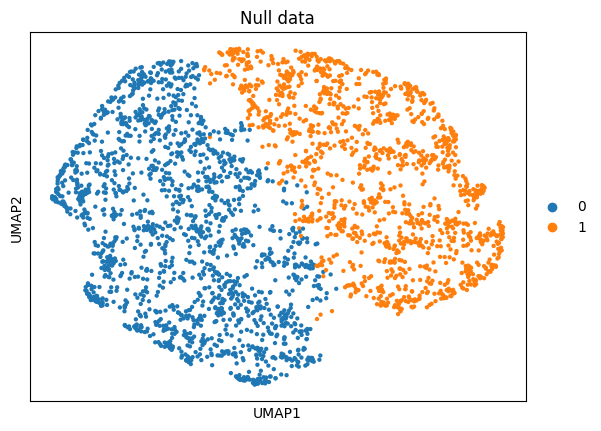

In [24]:
sc.pl.umap(
    data_null_gen,
    color=f"leiden_{best_split}",
    alpha=1,
    cmap="viridis",
    title="Null data",
)
plt.show()

In [25]:
data_null_gen.obs["leiden_best"] = data_null_gen.obs[f"leiden_{best_split}"]

data_null_gen.write(data_path + "/outs_raw_counts" + "/null_data_opt.h5ad")

In [26]:
clusters = data.obs["leiden_opt"].unique()
DEs_log_gen = {}
pvals_log_gen = {}
fdr = 0.05
rng = np.random.default_rng(1234)

for c in clusters:

    X_data_0 = data_nonzero.X[data_nonzero.obs["leiden_opt"] == c].copy()
    X_data_1 = data_nonzero.X[data_nonzero.obs["leiden_opt"] != c].copy()

    n_cells_0 = X_data_0.shape[0]
    n_cells_1 = X_data_1.shape[0]

    X_null_gen_0 = data_null_gen.X[data_null_gen.obs[f"leiden_best"] != "0"]
    X_null_gen_0 = X_null_gen_0[rng.integers(X_null_gen_0.shape[0], size=n_cells_0), :]
    X_null_gen_1 = data_null_gen.X[data_null_gen.obs[f"leiden_best"] == "0"]
    X_null_gen_1 = X_null_gen_1[rng.integers(X_null_gen_1.shape[0], size=n_cells_1), :]
    null_pvals = ranksums(X_null_gen_0, X_null_gen_1, alternative="two-sided").pvalue

    pvals_data = ranksums(X_data_0, X_data_1, alternative="two-sided").pvalue
    p_data = pd.DataFrame({"pval_data": pvals_data}, index=data_nonzero.var.index)
    pval_null_gen = pd.DataFrame(
        {"pval_null": null_pvals}, index=data_null_gen.var.index
    )

    DE_TU, pval_TU = cd.call_de(
        p_data, pval_null_gen, FDR=fdr, correct=False, nlog=True
    )
    data_nonzero.var[f"pval_cluster_{c}_gen"] = pval_TU["pval_data"]
    data_nonzero.var[f"q_cluster_{c}_gen"] = pval_TU["q"]
    data_nonzero.var[f"DE_cluster_{c}_gen"] = (
        data_nonzero.var[f"q_cluster_{c}_gen"] < fdr
    )

    DEs_log_gen[c] = DE_TU
    pvals_log_gen[c] = pval_TU
    print(
        f"Cluster {c} - DE genes: {len(DEs_log_gen[c])}; Minimum q value: {np.min(pvals_log_gen[c]['q'])}"
    )

Cluster 1 - DE genes: 0; Minimum q value: 0.14689680499449137
Cluster 0 - DE genes: 50; Minimum q value: 0.02
Cluster 2 - DE genes: 0; Minimum q value: 1.0
Cluster 4 - DE genes: 0; Minimum q value: 0.07692307692307693
Cluster 3 - DE genes: 5090; Minimum q value: 0.02887844190732035


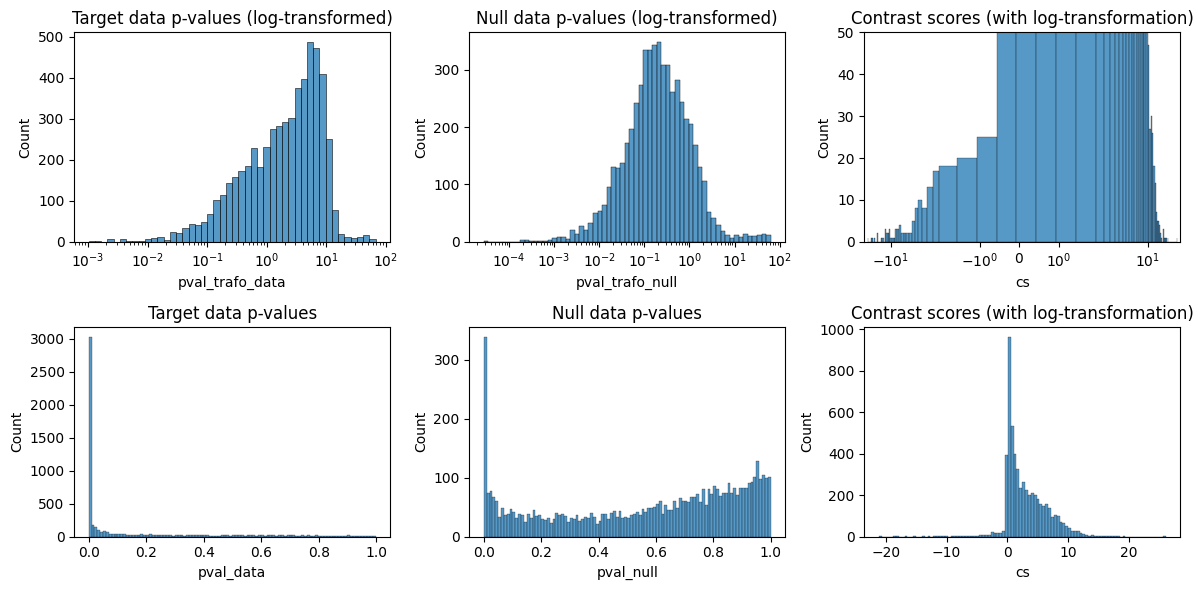

In [27]:
c = "3"

fig, ax = plt.subplots(2, 3, figsize=(12, 6))
sns.histplot(pvals_log_gen[c], x="pval_trafo_data", ax=ax[0, 0], log_scale=True)
ax[0, 0].set_title("Target data p-values (log-transformed)")
sns.histplot(pvals_log_gen[c], x="pval_trafo_null", ax=ax[0, 1], log_scale=True)
ax[0, 1].set_title("Null data p-values (log-transformed)")

sns.histplot(pvals_log_gen[c], x="cs", ax=ax[0, 2])
ax[0, 2].set_title("Contrast scores (with log-transformation)")
ax[0, 2].set(xscale="symlog", ylim=(0, 50))

sns.histplot(pvals_log_gen[c], x="pval_data", ax=ax[1, 0], bins=100)
ax[1, 0].set_title("Target data p-values")
sns.histplot(pvals_log_gen[c], x="pval_null", ax=ax[1, 1], bins=100)
ax[1, 1].set_title("Null data p-values")

sns.histplot(pvals_log_gen[c], x="cs", ax=ax[1, 2], bins=100)
ax[1, 2].set_title("Contrast scores (with log-transformation)")


plt.tight_layout()
plt.show()

In [28]:
for c in clusters:
    print(f"cluster {c}")
    print(pvals_log_gen[c]["q"].value_counts().sort_index())
    print("")

cluster 1
0.146897    2723
0.147156       2
0.147307       4
0.147624     238
0.147826      23
            ... 
0.249492       1
0.249661       5
0.250733       1
0.251128       1
1.000000    1120
Name: q, Length: 357, dtype: int64

cluster 0
0.020000      50
0.074074       4
0.083333       6
0.131148       1
0.138462       4
            ... 
0.642750       1
0.642857       1
0.643069      30
0.643174       1
1.000000    2175
Name: q, Length: 322, dtype: int64

cluster 2
1.0    5552
Name: q, dtype: int64

cluster 4
0.076923      13
0.176471       4
0.222222       1
0.333333       3
0.409091       1
0.458333       2
0.600000       1
0.785714       3
0.827586       1
1.000000    5523
Name: q, dtype: int64

cluster 3
0.028878    1489
0.028909      33
0.029202      19
0.029223     170
0.029349     163
            ... 
0.064374       1
0.064541       2
0.064913       1
0.065860       1
1.000000     344
Name: q, Length: 143, dtype: int64



In [29]:
data_nonzero.uns["ClusterDE_results"] = pvals_log_gen

data_nonzero.uns["ClusterDE_results"]["params"] = {
    "groupby": "leiden_opt",
    "reference": "rest",
    "use_raw": False,
    "layer": None,
}

In [30]:
data_nonzero.write(data_path + "/filtered_data_maxpool_processed_cluster.h5ad")

... storing 'gene_dist' as categorical


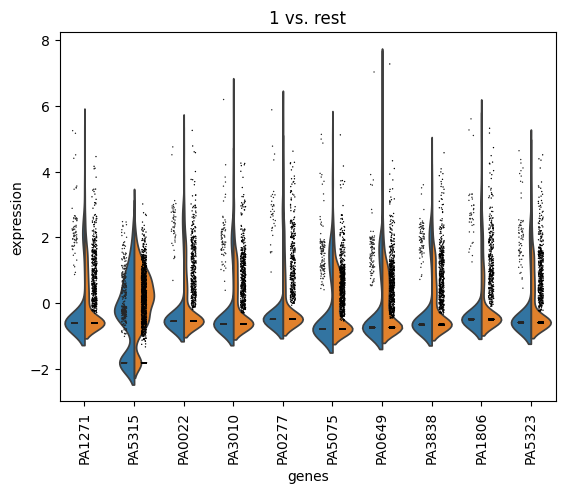

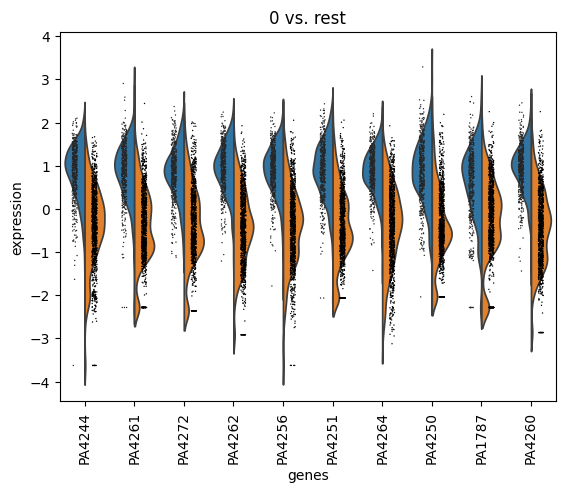

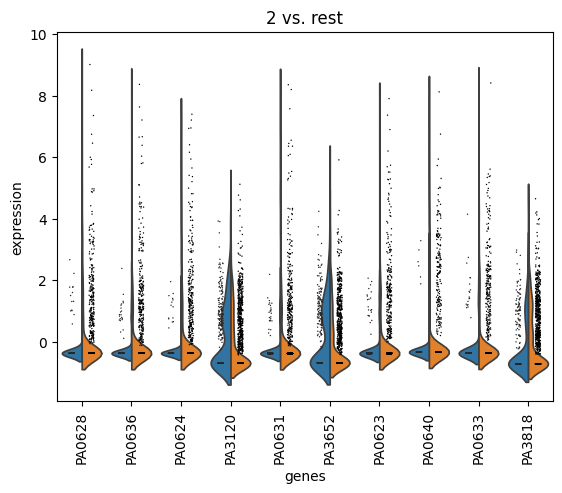

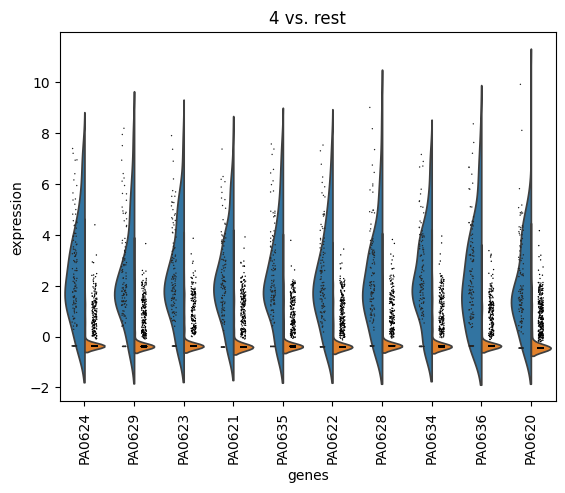

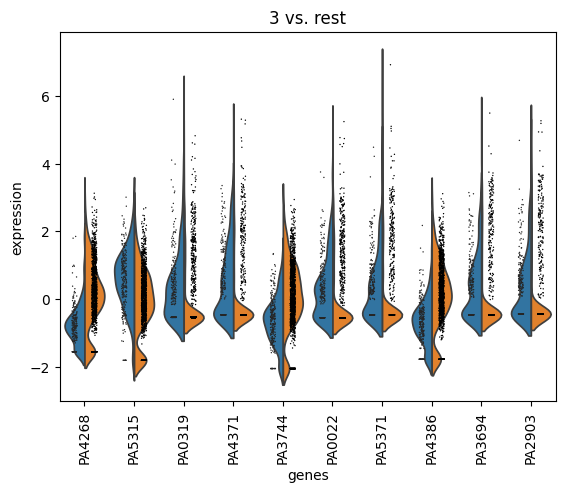

In [32]:
n_genes = 10
for c in clusters:
    plot_genes = (
        data_nonzero.uns["ClusterDE_results"][c].iloc[:n_genes, :].index.tolist()
    )
    sc.pl.rank_genes_groups_violin(
        data_nonzero, gene_names=plot_genes, key="ClusterDE_results", groups=c
    )

In [35]:
all_marker_genes = []
for c in clusters:
    plot_genes = (
        data_nonzero.uns["ClusterDE_results"][c].iloc[:n_genes, :].index.tolist()
    )
    all_marker_genes += plot_genes

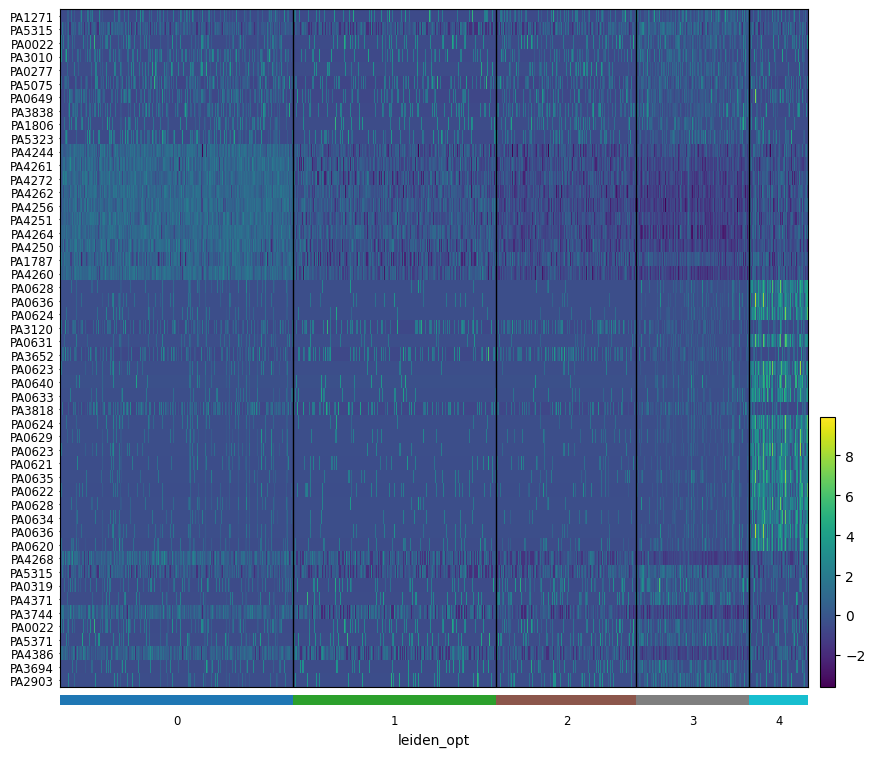

In [36]:
sc.pl.heatmap(data_nonzero, all_marker_genes, groupby="leiden_opt", swap_axes=True)